# Import Libraries

In [1]:
from ase.visualize import view
from ase.io import read
from ase.data import atomic_numbers, vdw_radii
from ase.build import surface
from ase.build import add_adsorbate
from ase import Atoms
import numpy as np
from typing import List, Tuple, Optional
from scipy.spatial import KDTree
from itertools import combinations
import nglview
from tqdm import tqdm
from scipy.spatial import cKDTree

c:\Users\dangh\AppData\Local\Programs\Python\Python313\Lib\site-packages\nglview\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Supporting Functions

In [2]:
def atomic_radii(structure_path):
    """
    Trích xuất bán kính nguyên tử từ structure file .
    
    Parameters:
    -----------
    structure_path : str
        Đường dẫn đến file .
    
    Returns:
    --------
    radii_dict : dict
        Từ điển chứa tên nguyên tố và bán kính van der Waals.
    """
    try:
        atoms = read(structure_path)
    except Exception as e:
        raise ValueError(f"Không thể đọc file : {e}")
    
    elements = set(atoms.get_chemical_symbols())
    radii_dict = {}
    for element in elements:
        atomic_number = atomic_numbers[element]
        radius = vdw_radii[atomic_number] if vdw_radii[atomic_number] != 0 else 1.0
        radii_dict[element] = radius
        print(f"{element} radius: {radius}")
    
    return radii_dict

def molecule_surface_area(atoms, atom_radii, num_points=100000):
    """
    Tính diện tích bề mặt của phân tử theo góc nhìn từ trên xuống (mặt phẳng xy) bằng phương pháp Monte Carlo.

    Parameters:
    - atoms: ASE Atoms object, chứa thông tin vị trí và ký hiệu hóa học của các nguyên tử
    - atom_radii: dict, chứa bán kính nguyên tử (ví dụ: {'Al': 1.43, 'C': 1.7, 'H': 1.0})
    - num_points: int, số điểm ngẫu nhiên cho ước lượng Monte Carlo

    Returns:
    - area_angstrom2: float, diện tích bề mặt ước lượng (Å²)
    - area_nm2: float, diện tích bề mặt ước lượng (nm²)
    """
    # Lấy tọa độ x, y (bỏ qua z) từ đối tượng Atoms
    coords_xy = np.array([atom.position[:2] for atom in atoms])  # Shape (n_atoms, 2)

    # Lấy bán kính dựa trên ký hiệu hóa học
    radii = np.array([atom_radii[atom.symbol] for atom in atoms])  # Shape (n_atoms,)

    # Tìm hộp giới hạn (bounding box)
    min_x = np.min(coords_xy[:, 0] - radii)
    max_x = np.max(coords_xy[:, 0] + radii)
    min_y = np.min(coords_xy[:, 1] - radii)
    max_y = np.max(coords_xy[:, 1] + radii)

    # Tính diện tích hộp giới hạn
    box_area = (max_x - min_x) * (max_y - min_y)

    # Tạo điểm ngẫu nhiên trong hộp giới hạn
    points_x = np.random.uniform(min_x, max_x, num_points)
    points_y = np.random.uniform(min_y, max_y, num_points)
    points = np.vstack((points_x, points_y)).T  # Shape (num_points, 2)

    # Kiểm tra xem các điểm có nằm trong hình tròn của nguyên tử nào không
    inside_count = 0
    for i in range(num_points):
        for j, center in enumerate(coords_xy):
            distance = np.sqrt(np.sum((points[i] - center) ** 2))
            if distance <= radii[j]:
                inside_count += 1
                break  # Điểm nằm trong ít nhất một hình tròn, không cần kiểm tra tiếp

    # Tính diện tích
    area_angstrom2 = (inside_count / num_points) * box_area
    area_nm2 = area_angstrom2 / 100  # Chuyển từ Å² sang nm²
    print(f"Diện tích bề mặt phân tử (Top view): {area_angstrom2:.2f} Å², {area_nm2:.4f} nm²")
    return area_angstrom2, area_nm2

# Hàm tính khoảng cách vector hóa
def compute_distances_vectorized(coords1, coords2):
    # Hàm dùng để kiểm tra sự chồng chéo của các điểm trên bề mặt - Steric Hindrance
    diff = coords1[:, np.newaxis] - coords2  # Shape (n1, n2, 3)
    distances = np.sqrt(np.sum(diff**2, axis=2))  # Shape (n1, n2)
    return distances

# Hàm xoay phân tử ngẫu nhiên theo trục Z
def rotate_molecule_z_axis(adsorbate):
    """
    Rotate an ASE Atoms object around the Z-axis passing through the main atom (index 0)
    by a random angle in [0, 360) degrees.
    
    Parameters:
    adsorbate : ASE Atoms
        The molecule to rotate, containing atomic positions.
    
    Returns:
    rotated_adsorbate : ASE Atoms
        A copy of the input molecule with all atoms rotated around the Z-axis through the main atom.
    """
    # Create a copy to avoid modifying the original
    rotated_adsorbate = adsorbate.copy()
    
    # Get the position of the main atom (index 0) as pivot
    pivot = rotated_adsorbate[0].position.copy()
    
    # Generate random angle in degrees
    theta = np.random.uniform(0, 360)
    
    # Convert angle to radians
    theta_rad = np.radians(theta)
    
    # Rotation matrix for Z-axis
    rotation_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0],
        [np.sin(theta_rad), np.cos(theta_rad), 0],
        [0, 0, 1]
    ])
    
    # Translate all atoms so that pivot is at origin
    rotated_adsorbate.positions -= pivot
    
    # Apply rotation
    rotated_adsorbate.positions = np.dot(rotated_adsorbate.positions, rotation_matrix.T)
    
    # Translate back to restore pivot position
    rotated_adsorbate.positions += pivot
    
    return rotated_adsorbate

# Precursor/Inhibitor Configuration

In [3]:
def atomic_positions(structure_path):
    """
    Đọc file cấu trúc (.xyz, .cif, ...) và in ký hiệu cùng tọa độ các nguyên tử.
    """
    atoms = read(structure_path)
    radius = atomic_radii(structure_path)
    #view(atoms)
    print("Atomic symbols:", atoms.get_chemical_symbols())
    print("Atomic positions (Å):")
    print(atoms.positions)
    # In từng nguyên tử
    for symbol, pos in zip(atoms.get_chemical_symbols(), atoms.positions):
        print(f"{symbol}: x={pos[0]:.4f}, y={pos[1]:.4f}, z={pos[2]:.4f}")
    return atoms, radius

def atomic_remove_indices(atoms, remove_indices=None):
    """
    Xóa các nguyên tử theo chỉ số index, rồi in ra cấu trúc còn lại.
    """

    if remove_indices:
        # Tạo danh sách các index cần giữ lại
        keep_mask = [i not in remove_indices for i in range(len(atoms))]
        atoms = atoms[keep_mask]

    # Hiển thị và in thông tin
    #view(atoms)
    print(f"Sau khi loại bỏ nguyên tử thứ {remove_indices}, cấu trúc phân tử mới là:")
    for i, (s, p) in enumerate(zip(atoms.get_chemical_symbols(), atoms.positions)):
        print(f"{i}: {s} - x={p[0]:.8f}, y={p[1]:.8f}, z={p[2]:.8f}")

    return atoms


# Hàm random coords cho phân tử
def generate_random_position_and_rotation(slab, adsorption_sites, z_offset=2.0, angle_range=(1, 360)):
    """
    Generate a random position strictly within the 2D surface of the slab (including non-rectangular cells),
    and rotation matrices.

    Parameters:
    - slab: ASE Atoms object
    - z_offset: float, distance above the top surface
    - angle_range: tuple, rotation angle range in degrees

    Returns:
    - position: (1, 3) np.ndarray, absolute cartesian coordinates [x, y, z]
    - rotx, roty, rotz: rotation matrices
    """
    import numpy as np

    # Get cell vectors
    cell = slab.get_cell()  # shape (3, 3)
    a1, a2 = cell[0], cell[1]  # Only surface plane
    #adsorption_sites[0][2]
    z_ads_max = np.max(np.array(adsorption_sites)[:, 2])
    z_value = z_ads_max + z_offset

    # Random fractional coords in 2D unit cell
    r1 = np.random.rand()
    r2 = np.random.rand()

    # Compute cartesian xy from lattice vectors
    xy = r1 * a1 + r2 * a2
    position = np.array([[xy[0], xy[1], z_value]])

    # Rotation angles
    alpha = np.radians(np.random.uniform(*angle_range))
    beta  = np.radians(np.random.uniform(*angle_range))
    gamma = np.radians(np.random.uniform(*angle_range))

    # Rotation matrices
    rotx = np.array([
        [1, 0, 0],
        [0, np.cos(alpha), -np.sin(alpha)],
        [0, np.sin(alpha), np.cos(alpha)]
    ])
    roty = np.array([
        [np.cos(beta), 0, np.sin(beta)],
        [0, 1, 0],
        [-np.sin(beta), 0, np.cos(beta)]
    ])
    rotz = np.array([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])

    return position, rotx, roty, rotz



def rotate_adsorbate_flexible(adsorbate, ads_site, v1_type='two_atoms', indices=None):
    """
    Quay phân tử tiền chất để căn chỉnh vector từ main atom với ontop_site, linh hoạt giữa hai nguyên tử hoặc centroid/midpoint.
    
    Parameters:
    -----------
    adsorbate : ASE Atoms
        Đối tượng phân tử tiền chất (từ atomic_remove_indices).
    ontop_site : list
        Tọa độ (x, y, z) của site hấp phụ trên bề mặt.
    v1_type : str, optional
        Loại vector v1: 'two_atoms' (vector giữa 2 nguyên tử) hoặc 'centroid' (midpoint cho 2 nguyên tử, centroid cho 3+). Mặc định là 'two_atoms'.
    indices : list, optional
        Danh sách index của nguyên tử:
        - Với 'two_atoms': 2 index (thứ hai phải khác 0).
        - Với 'centroid': 2 hoặc nhiều index (khác 0) để tính midpoint/centroid.
        Nếu None, mặc định là [0, 1] cho 'two_atoms' hoặc [1, 2] cho 'centroid'.
    
    Returns:
    --------
    rotated_adsorbate : ASE Atoms
        Đối tượng phân tử đã xoay với main atom tại vị trí ban đầu, cần dịch thủ công đến ontop_site.
    angle : float
        Góc quay (radian) được áp dụng.
    axis : list
        Trục quay (x, y, z) được sử dụng.
    """
    from scipy.spatial.transform import Rotation as R
    import numpy as np
    
    # Sao chép adsorbate để xử lý
    rotated_adsorbate = adsorbate.copy()
    
    # Pivot là main atom (nguyên tử đầu tiên, index 0)
    pivot = rotated_adsorbate[0].position.copy()
    
    # Xử lý indices mặc định
    if indices is None:
        indices = [1] if v1_type == 'two_atoms' else [1, 2]
    if v1_type == 'two_atoms' and len(indices) != 2:
        indices = [1]  # Mặc định lấy nguyên tử thứ hai nếu không đủ 2 index
    
    # Tính vector v1
    if v1_type == 'two_atoms':
        if len(indices) < 2:
            raise ValueError("Cần ít nhất 2 index cho v1_type 'two_atoms'.")
        v1_start = pivot
        v1_end = rotated_adsorbate.positions[indices[1]]
        v1 = v1_end - v1_start
    elif v1_type == 'centroid':
        if len(indices) < 2:
            raise ValueError("Cần ít nhất 2 index cho v1_type 'centroid'.")
        other_atoms_positions = [rotated_adsorbate.positions[i] for i in indices]
        if len(indices) == 2:
            # Trung điểm của 2 nguyên tử
            midpoint = np.mean(other_atoms_positions, axis=0)
            v1 = midpoint - pivot
        else:
            # Centroid của 3 hoặc nhiều nguyên tử
            centroid = np.mean(other_atoms_positions, axis=0)
            v1 = centroid - pivot
    else:
        raise ValueError("v1_type phải là 'two_atoms' hoặc 'centroid'.")
    
    # Vector mục tiêu: từ main atom đến ads_site
    v2 = ads_site - pivot
    
    # Chuẩn hóa vector
    v1 /= np.linalg.norm(v1)
    v2 /= np.linalg.norm(v2)
    
    # Tính toán góc quay
    cross = np.cross(v1, v2)
    dot = np.dot(v1, v2)
    if np.linalg.norm(cross) < 1e-8:  # Vector thẳng hàng hoặc ngược chiều
        if dot < 0:
            axis = np.array([1, 0, 0]) if not np.allclose(v1, [1, 0, 0]) else np.array([0, 1, 0])
            angle = np.pi
        else:
            axis = np.array([0, 0, 1])  # Không cần quay
            angle = 0.0
    else:
        axis = cross / np.linalg.norm(cross)
        angle = np.arccos(np.clip(dot, -1.0, 1.0))
    
    # Tạo đối tượng Rotation
    rotation = R.from_rotvec(angle * axis)
    
    # Áp dụng quay quanh pivot
    rotated_adsorbate.translate(-pivot)  # Dịch pivot về gốc
    rotated_adsorbate.positions = rotation.apply(rotated_adsorbate.positions)
    rotated_adsorbate.translate(pivot)   # Dịch lại về vị trí ban đầu
    
    # Dịch main atom đến ads_site (không thêm vào slab)
    #offset = ads_site - rotated_adsorbate[0].position
    #rotated_adsorbate.translate(offset)
    view(rotated_adsorbate)
    print(f"\nApplied rotation - Angle: {np.degrees(angle):.1f}°, Axis: [{axis[0]:.2f}, {axis[1]:.2f}, {axis[2]:.2f}]")
    print(f"v1_type: {v1_type}, Indices used: {indices}")

    
    return rotated_adsorbate, angle, axis


# Substrate Surface Configuration

In [4]:
def generate_slab_from_cif(cif_path, miller_indices=(1, 0, 0), layers=4, vacuum=10.0, size=(1, 1, 1), repeat=(4, 4, 1)):
    """
    Tạo một bề mặt slab từ file CIF với chỉ số Miller tùy chỉnh, tính diện tích bề mặt và giới hạn.

    Parameters:
    -----------
    cif_path : str
        Đường dẫn đến file CIF chứa cấu trúc tinh thể.
    miller_indices : tuple, optional
        Chỉ số Miller (h, k, l) để xác định mặt phẳng bề mặt. Mặc định là (1, 0, 0).
    layers : int, optional
        Số lớp nguyên tử trong slab. Mặc định là 4.
    vacuum : float, optional
        Khoảng chân không (Å) dọc theo trục z. Mặc định là 10.0.
    size : tuple, optional
        Kích thước ban đầu của cấu trúc (nx, ny, nz) trước khi lặp lại. Mặc định là (1, 1, 1).
    repeat : tuple, optional
        Số lần lặp lại theo x, y, z để mở rộng slab. Mặc định là (4, 4, 1).

    Returns:
    --------
    result : tuple
        (slab, surface_area, x_min, x_max, y_min, y_max)
        - slab: ASE Atoms object, đối tượng slab đã được tạo
        - surface_area: float, diện tích bề mặt (nm²) tính từ hộp giới hạn xy
        - x_min, x_max, y_min, y_max: float, giới hạn tọa độ trong mặt phẳng xy (Å)
    """
    # Đọc cấu trúc từ file CIF
    structure = read(cif_path)

    # Tạo bề mặt dựa trên chỉ số Miller
    slab = surface(structure, miller_indices, layers=layers, vacuum=vacuum)

    # Lặp lại slab để tăng kích thước
    slab = slab.repeat(repeat)

    # Bật PBC cho cả ba hướng
    slab.pbc = [True, True, True]

    # Tính diện tích bề mặt chính xác theo cell vectors (Å²)
    a1 = slab.cell[0]  # Vector theo x
    a2 = slab.cell[1]  # Vector theo y
    surface_area_angstrom2 = np.linalg.norm(np.cross(a1, a2))
    surface_area_nm2 = surface_area_angstrom2 / 100  # 1 nm² = 100 Å²

    # In thông tin slab
    print(f"Slab created with Miller indices {miller_indices} and {len(slab)} atoms:")
    print(f"Cell: {slab.cell}")
    print(f"Surface area: {surface_area_nm2:.4f} nm²")
    '''
    print("Atomic positions with symbols:")
    for i, (symbol, pos) in enumerate(zip(slab.get_chemical_symbols(), slab.positions)):
        print(f"Atom {i}: {symbol} - x={pos[0]:.4f}, y={pos[1]:.4f}, z={pos[2]:.4f}")
    '''

    return slab, surface_area_nm2


def adsorption_sites(slab: Atoms, nx: int = 3, ny: int = 2, distance: Optional[float] = None, site_type: str = "ontop", atom1_idx: Optional[int] = None, atom2_idx: Optional[int] = None) -> Tuple[Atoms, np.ndarray, List[np.ndarray]]:
    """
    Determine adsorption sites on the top layer of a flat slab surface by selecting atoms with
    x-coordinates <= the nth smallest x-value and y-coordinates <= the nth smallest y-value,
    and calculate specific adsorption sites (ontop, bridge, hollow3, hollow4) based on distance.
    Visualize all top layer atoms with filtered atoms highlighted. selected_positions is used
    only to calculate distance if atom1_idx and atom2_idx are provided.

    Parameters:
    -----------
    slab : ASE Atoms
        The slab structure from generate_slab_from_cif.
    nx : int, optional
        Number of smallest x-coordinates to define the upper x-limit. Default is 3.
    ny : int, optional
        Number of smallest y-coordinates to define the upper y-limit. Default is 2.
    distance : float, optional
        Distance between neighboring atoms to determine adsorption sites. If None, calculated from atom1_idx and atom2_idx.
    site_type : str, optional
        Type of adsorption site to calculate ('ontop', 'bridge', 'hollow3', 'hollow4'). Default is 'ontop'.
    atom1_idx : int, optional
        Index of the first atom to calculate distance. Default is None.
    atom2_idx : int, optional
        Index of the second atom to calculate distance. Default is None.

    Returns:
    --------
    combined_atoms : ASE Atoms
        Combined Atoms object containing all top layer atoms (original colors) plus filtered atoms highlighted in red.
    selected_positions : np.ndarray
        Array of selected atom positions within the defined region (used only for distance calculation).
    adsorption_sites : List[np.ndarray]
        List of calculated adsorption site coordinates (x, y, z) based on top_layer_positions.
    """
    # Step 1: Identify atoms in the top layer (exact Z maximum)
    positions = slab.get_positions()
    z_coords = positions[:, 2]
    z_max = np.max(z_coords)
    top_layer_mask = z_coords == z_max
    top_layer_positions = positions[top_layer_mask]
    top_layer_symbols = np.array(slab.get_chemical_symbols())[top_layer_mask]
    
    if len(top_layer_positions) == 0:
        raise ValueError("No atoms found in the top layer of the slab.")
    
    # Print number of atoms in the top layer
    print(f"Number of atoms in top layer at Z={z_max:.4f} Å: {len(top_layer_positions)}")
    
    # Step 2: Select nx smallest x-coordinates and ny smallest y-coordinates
    nth_x = nx
    nth_y = ny
    sorted_values_x = np.sort(np.unique(np.round(top_layer_positions[:, 0], decimals=10)))  # Sort x values
    sorted_values_y = np.sort(np.unique(np.round(top_layer_positions[:, 1], decimals=10)))  # Sort y values
    x_target = sorted_values_x[nth_x - 1]
    y_target = sorted_values_y[nth_y - 1]
    print(f"Giá trị X thứ {nth_x} nhỏ nhất: {x_target}")
    print(f"Giá trị Y thứ {nth_y} nhỏ nhất: {y_target}")

    mask = ((top_layer_positions[:, 0] <= x_target) & (top_layer_positions[:, 1] <= y_target))

    selected_positions = top_layer_positions[mask]
    selected_symbols = top_layer_symbols[mask]

    print(f"Các nguyên tử trong top layer với x <= {x_target} và y <= {y_target}:")
    for pos, sym in zip(selected_positions, selected_symbols):
        print(f"{sym}: {pos}")
    
    # Step 3: Calculate distance if not provided
    if distance is not None:
        print(f"Using provided distance: {distance:.8f} Å")
    elif atom1_idx is not None and atom2_idx is not None and 0 <= atom1_idx < len(selected_positions) and 0 <= atom2_idx < len(selected_positions):
        pos1 = selected_positions[atom1_idx][:2]  # First atom's x, y
        pos2 = selected_positions[atom2_idx][:2]  # Second atom's x, y
        distance = np.linalg.norm(pos1 - pos2)
        print(f"Khoảng cách XY giữa 2 nguyên tử {pos1} và {pos2}: {distance:.8f} Å (calculated from indices {atom1_idx} and {atom2_idx})")
    else:
        print("Warning: Distance not provided and not enough valid atom indices to calculate. Using default distance of 0.0 Å.")
        distance = 0.0
    '''
    print(f"Number of filtered atoms: {len(selected_positions)}")
    print("Filtered positions:")
    for i, pos in enumerate(selected_positions):
        print(f"  Atom {i}: ({pos[0]:.8f}, {pos[1]:.8f}, {pos[2]:.8f}) - {selected_symbols[i]}")
    '''
    
    if len(selected_positions) == 0:
        print("No atoms found with the selected x and y coordinate constraints.")
        return Atoms(), selected_positions, []

    # Step 4: Calculate adsorption sites
    adsorption_sites_list = calculate_adsorption_sites(top_layer_positions, distance, site_type)
    
    print(f"Number of calculated {site_type} adsorption sites: {len(adsorption_sites_list)}")
    print("Adsorption site positions:")
    for i, site in enumerate(adsorption_sites_list):
        print(f"  Site {i}: ({site[0]:.8f}, {site[1]:.8f}, {site[2]:.8f})")

    
    # Step 5: Create Atoms objects for visualization
    # All top layer atoms (original symbols and colors)
    top_layer_atoms = Atoms(
        symbols=top_layer_symbols,
        positions=top_layer_positions,
        cell=slab.get_cell(),
        pbc=slab.get_pbc()
    )
    
    # Filtered atoms (highlighted with 'X' symbol for red color)
    filtered_highlight_atoms = Atoms(
        symbols=['X'] * len(selected_positions),
        positions=selected_positions,
        cell=slab.get_cell(),
        pbc=slab.get_pbc()
    )
    
    # Combine both for visualization
    combined_atoms = top_layer_atoms + filtered_highlight_atoms
    
    # Visualize the combined structure
    print("Visualizing top layer atoms (original colors) with filtered atoms highlighted using ASE view...")
    
    # Return combined atoms, selected positions, and calculated adsorption sites
    return combined_atoms, selected_positions, adsorption_sites_list

def calculate_adsorption_sites(top_layer_positions: np.ndarray, distance: float, site_type: str) -> List[np.ndarray]:
    """
    Calculate adsorption sites (ontop, bridge, hollow3, hollow4) based on top layer positions and distance.

    Parameters:
    -----------
    top_layer_positions : np.ndarray
        Array of all atom positions in the top layer (Z_max).
    distance : float
        Distance between neighboring atoms to determine adsorption sites.
    site_type : str
        Type of adsorption site to calculate ('ontop', 'bridge', 'hollow3', 'hollow4').
    z_max : float
        Z-coordinate of the top layer.

    Returns:
    --------
    adsorption_sites : List[np.ndarray]
        List of calculated adsorption site coordinates (x, y, z).
    """
    adsorption_sites_list = []
    tolerance = 1e-5  # Tolerance for distance comparison

    if site_type == "ontop":
        # For ontop, use all top layer positions directly
        adsorption_sites_list = [pos for pos in top_layer_positions]
    else:
        for i, pos1 in enumerate(top_layer_positions):
            for j, pos2 in enumerate(top_layer_positions):
                if i < j:  # Avoid self-comparison and duplicate pairs
                    dist = np.linalg.norm(pos1[:2] - pos2[:2])
                    if np.isclose(dist, distance, rtol=tolerance, atol=tolerance):
                        # Bridge: Midpoint between two atoms
                        if site_type == "bridge":
                            bridge_site = (pos1 + pos2) / 2
                            #bridge_site = np.append(bridge_site, z_max)  # Add z-coordinate
                            # Check for duplicates using np.allclose
                            is_duplicate = False
                            for existing_site in adsorption_sites_list:
                                if np.allclose(bridge_site, existing_site, rtol=tolerance, atol=tolerance):
                                    is_duplicate = True
                                    break
                            if not is_duplicate:
                                adsorption_sites_list.append(bridge_site)
                        
                        # Hollow3: Center of a triangle (requires 3 atoms)
                        elif site_type == "hollow3":
                            for k, pos3 in enumerate(top_layer_positions):
                                if k > j:
                                    dist2 = np.linalg.norm(pos2[:2] - pos3[:2])
                                    dist3 = np.linalg.norm(pos1[:2] - pos3[:2])
                                    if (np.isclose(dist2, distance, rtol=tolerance, atol=tolerance) and
                                        np.isclose(dist3, distance, rtol=tolerance, atol=tolerance)):
                                        hollow3_site = (pos1 + pos2 + pos3) / 3
                                        #hollow3_site = np.append(hollow3_site, z_max)
                                        # Check for duplicates using np.allclose
                                        is_duplicate = False
                                        for existing_site in adsorption_sites_list:
                                            if np.allclose(hollow3_site, existing_site, rtol=tolerance, atol=tolerance):
                                                is_duplicate = True
                                                break
                                        if not is_duplicate:
                                            adsorption_sites_list.append(hollow3_site)
                        
                        # Hollow4: Center of a square (requires 4 atoms)
                        elif site_type == "hollow4":
                            for k, pos3 in enumerate(top_layer_positions):
                                if k > j:
                                    dist2 = np.linalg.norm(pos2[:2] - pos3[:2])
                                    if np.isclose(dist2, distance, rtol=tolerance, atol=tolerance):
                                        for l, pos4 in enumerate(top_layer_positions):
                                            if l > k:
                                                dist3 = np.linalg.norm(pos3[:2] - pos4[:2])
                                                dist4 = np.linalg.norm(pos1[:2] - pos4[:2])
                                                if (np.isclose(dist3, distance, rtol=tolerance, atol=tolerance) and
                                                    np.isclose(dist4, distance, rtol=tolerance, atol=tolerance)):
                                                    # Check if atoms form a square (approximate)
                                                    if np.allclose(np.abs(dist - dist2), 0, atol=tolerance) and \
                                                       np.allclose(np.abs(dist - dist3), 0, atol=tolerance) and \
                                                       np.allclose(np.abs(dist - dist4), 0, atol=tolerance):
                                                        hollow4_site = (pos1 + pos2 + pos3 + pos4) / 4
                                                        #hollow4_site = np.append(hollow4_site, z_max)
                                                        # Check for duplicates using np.allclose
                                                        is_duplicate = False
                                                        for existing_site in adsorption_sites_list:
                                                            if np.allclose(hollow4_site, existing_site, rtol=tolerance, atol=tolerance):
                                                                is_duplicate = True
                                                                break
                                                        if not is_duplicate:
                                                            adsorption_sites_list.append(hollow4_site)

    return adsorption_sites_list




# Run Simulation

In [5]:
N = 3                      # Số vòng lặp mô phỏng / Số cycle
N_gas = 10000              # Số phân tử trong mỗi lần mô phỏng (precursors or inhibitors)

# Số điểm hấp phụ trên bề mặt gần nhất với precursors/ inhibitors đang xét
MAX_SITES = 20

# Inhibitor và Precursor 
# Khởi tạo mảng với precursors
#number_gas_precursor = np.array([0])  # 1D, Shape (1,) Lưu lại số lượng phân tử khí trong gas phase với Precursors
#number_ads_precursor = np.array([0])  # 1D, Shape (1,) Lưu lại số lượng phân tử khí đã hấp phụ trên bề mặt với Precursors
#Sn_ads_phase_t = np.array([[-10, -10, -10]])  # 2D, Shape (1, 3) Lưu giá trị nguyên tử trong tiền chất TMA ở pha hấp phụ
#Cl_ads_phase_t = np.array([[-10, -10, -10]])   # 2D, Shape (1, 3) Lưu giá trị nguyên tử trong tiền chất TMA ở pha hấp phụ

# Khởi tạo mảng với inhibitors
#number_gas_inhibitor = np.array([0])  # 1D, Shape (1,) Lưu lại số lượng phân tử khí trong gas phase với Inhibitors
#number_ads_inhibitor = np.array([0])  # 1D, Shape (1,) Lưu lại số lượng phân tử khí đã hấp phụ trên bề mặt với Inhibitors
#S_ads_phase_t_ET = np.array([[-10, -10, -10]])  # Shape (1, 3) Lưu giá trị nguyên tử S trong inhibitor ET ở pha hấp phụ
#C_ads_phase_t_ET = np.array([[-10, -10, -10]])  # Shape (1, 3) Lưu giá trị nguyên tử C trong inhibitor ET ở pha hấp phụ
#H_ads_phase_t_ET = np.array([[-10, -10, -10]])  # Shape (1, 3) Lưu giá trị nguyên tử H trong inhibitor ET ở pha hấp phụ




In [6]:

slab, surface_area_nm2 = generate_slab_from_cif(r"C:\Users\dangh\Documents\TaiLieu\ThS Phenikaa\AS-ALD Simulation\CIF Files\SiO2_mp-8352_computed.cif",
                              miller_indices=(1, 1, 1), layers=4, vacuum=10.0, size=(1, 1, 1), repeat=(20, 20, 1))

view(slab, viewer='ngl')

Slab created with Miller indices (1, 1, 1) and 9600 atoms:
Cell: Cell([[105.51260719999999, 0.0, 0.0], [52.75630359999998, 91.37659825472883, 0.0], [0.0, 0.0, 35.6148112980221]])
Surface area: 96.4138 nm²


In [7]:
#print(radius["Sn"])
#print(molecules.positions)
#print(molecules.positions[4,2])
atoms, radius = atomic_positions(r"C:\Users\dangh\Documents\TaiLieu\ThS Phenikaa\AS-ALD Simulation\sn_cl_structure.cif")
# Xóa nguyên tử ở dòng 1 và 3 (tính từ 0)
atoms_filtered = atomic_remove_indices(atoms, remove_indices=[1])
_, _, adsorption_sites = adsorption_sites(slab, nx=3, ny=2, site_type="hollow3", atom1_idx=0, atom2_idx=1)

# Build k-d tree
cu_tree = cKDTree(adsorption_sites)
# Đánh số thứ tự cho các điểm
order_sub = np.arange(1, len(adsorption_sites) + 1)  # Mảng 1D từ 1 đến số điểm hấp phụ

# Chọn site đầu tiên để thử nghiệm
selected_site = adsorption_sites[0]
# Quay phân tử
rotated_adsorbate, angle, axis = rotate_adsorbate_flexible(atoms_filtered, selected_site, v1_type='centroid', indices=[1, 2, 3])
# Tính diện tích bề mặt
molecule_area_angstrom2, molecule_area_nm2 = molecule_surface_area(rotated_adsorbate, atom_radii=radius)


#add_adsorbate(slab, rotated_adsorbate, height=2, position=(selected_site[0], selected_site[1]), offset=(0, 0))

Sn radius: 2.17
Cl radius: 1.75
Atomic symbols: ['Sn', 'Cl', 'Cl', 'Cl', 'Cl']
Atomic positions (Å):
[[3.16851134 1.83746502 2.3883634 ]
 [0.82791464 1.83786156 2.38816274]
 [3.94971036 4.04376269 2.38816274]
 [3.94811464 0.73466495 4.2998625 ]
 [3.94881217 0.73386231 0.4777625 ]]
Sn: x=3.1685, y=1.8375, z=2.3884
Cl: x=0.8279, y=1.8379, z=2.3882
Cl: x=3.9497, y=4.0438, z=2.3882
Cl: x=3.9481, y=0.7347, z=4.2999
Cl: x=3.9488, y=0.7339, z=0.4778
Sau khi loại bỏ nguyên tử thứ [1], cấu trúc phân tử mới là:
0: Sn - x=3.16851134, y=1.83746502, z=2.38836340
1: Cl - x=3.94971036, y=4.04376269, z=2.38816274
2: Cl - x=3.94811464, y=0.73466495, z=4.29986250
3: Cl - x=3.94881217, y=0.73386231, z=0.47776250
Number of atoms in top layer at Z=25.6148 Å: 400
Giá trị X thứ 3 nhỏ nhất: 7.91344554
Giá trị Y thứ 2 nhỏ nhất: 6.091773217
Các nguyên tử trong top layer với x <= 7.91344554 và y <= 6.091773217:
O: [ 2.63781518  1.5229433  25.6148113 ]
O: [ 5.27563036  6.09177322 25.6148113 ]
Khoảng cách XY giữa 

In [8]:
view(atoms)

<Popen: returncode: None args: ['c:\\Users\\dangh\\AppData\\Local\\Programs\...>

In [9]:
#print(radius["Sn"])
#print(molecules.positions)
#print(molecules.positions[4,2])
inhibitor_atoms, inhibitor_radius = atomic_positions(r"C:\Users\dangh\Documents\TaiLieu\ThS Phenikaa\AS-ALD Simulation\CIF Files\Conformer3D_COMPOUND_CID_6343.sdf")
# Xóa nguyên tử (tính từ 0)
atoms_filtered = atomic_remove_indices(inhibitor_atoms, remove_indices=[8])
# Quay phân tử
rotated_inhibitor, angle, axis = rotate_adsorbate_flexible(atoms_filtered, selected_site, v1_type='centroid', indices=[0,1])
#view(atoms_filtered)
inhibitor_area_angstrom2, inhibitor_area_nm2 = molecule_surface_area(rotated_inhibitor, atom_radii=inhibitor_radius)
# Kết hợp các từ điển radius
radius = radius.copy()  # Bắt đầu với radius của precursor
radius.update(inhibitor_radius)   # Cập nhật với radius của inhibitor, giữ các giá trị không trùng lặp

H radius: 1.2
C radius: 1.7
S radius: 1.8
Atomic symbols: ['S', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']
Atomic positions (Å):
[[ 1.4415 -0.2624  0.    ]
 [-0.142   0.6214  0.    ]
 [-1.2995 -0.359   0.    ]
 [-0.1882  1.2622  0.8857]
 [-0.1882  1.2622 -0.8857]
 [-1.2851 -0.9984 -0.8892]
 [-1.2851 -0.9984  0.8893]
 [-2.2492  0.1861  0.    ]
 [ 2.2236  0.8269  0.    ]]
S: x=1.4415, y=-0.2624, z=0.0000
C: x=-0.1420, y=0.6214, z=0.0000
C: x=-1.2995, y=-0.3590, z=0.0000
H: x=-0.1882, y=1.2622, z=0.8857
H: x=-0.1882, y=1.2622, z=-0.8857
H: x=-1.2851, y=-0.9984, z=-0.8892
H: x=-1.2851, y=-0.9984, z=0.8893
H: x=-2.2492, y=0.1861, z=0.0000
H: x=2.2236, y=0.8269, z=0.0000
Sau khi loại bỏ nguyên tử thứ [8], cấu trúc phân tử mới là:
0: S - x=1.44150000, y=-0.26240000, z=0.00000000
1: C - x=-0.14200000, y=0.62140000, z=0.00000000
2: C - x=-1.29950000, y=-0.35900000, z=0.00000000
3: H - x=-0.18820000, y=1.26220000, z=0.88570000
4: H - x=-0.18820000, y=1.26220000, z=-0.88570000
5: H - x=-1.28510000, 

# TEST 2

In [10]:
'''
Đoạn code này mô phỏng quá trình hấp phụ của inhibitors và precursors trên bề mặt slab kèm chất đồng phản ứng H2O 
theo quy trình ALD với các chu kỳ được xác định rõ ràng.
n = số lần lặp quá trình trong 1 chu kỳ
N_gas = số phân tử trong 1 lần lặp
'''
from ase import Atoms
from ase.visualize import view
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree

# Đảm bảo có bán kính cho O (từ phản ứng H2O)
if 'O' not in radius:
    radius['O'] = 1.52  # Bán kính van der Waals của O, đơn vị Å (có thể điều chỉnh)

# Thêm các tham số mô phỏng (nếu chưa có)
n = 5  # Số lần lặp quá trình trong 1 chu kỳ
N_gas = 7500  # Số phân tử trong 1 lần lặp
N = 20  # Số chu kỳ ALD
    
# Khởi tạo danh sách để lưu trữ các phân tử
inhibitor_phase_molecules = []  # Phân tử inhibitors trong giai đoạn khí (chỉ chu kỳ 1)
ads_inhibitor_molecules = []   # Phân tử inhibitors đã hấp phụ (chỉ chu kỳ 1)
ads_phase_molecules = []       # Phân tử precursors đã hấp phụ (tất cả chu kỳ)

# Mảng theo dõi số lượng phân tử
number_gas_inhibitors = np.array([])
number_ads_inhibitors = np.array([])
number_gas_precursor = np.array([])
number_ads_precursor = np.array([])

# Định nghĩa z-offset cho hấp phụ ontop (Sn trên O)
z_offset = 2.0  # Khoảng cách Sn-O, đơn vị Å (có thể điều chỉnh)

# Dictionary để lưu thông tin về chu kỳ của mỗi vị trí hấp phụ và phân tử
adsorption_cycle_info = {}  # key: (x, y, z) tuple của vị trí O, value: chu kỳ
molecules_by_cycle = {}     # key: chu kỳ, value: list các phân tử

# Khởi tạo cu_tree ban đầu với adsorption_sites
cu_tree = cKDTree(adsorption_sites)

# Khởi tạo thông tin chu kỳ cho các vị trí ban đầu (chu kỳ 0 - substrate)
for site in adsorption_sites:
    adsorption_cycle_info[tuple(site)] = 0

for cycle in range(1, N+1):
    print(f'\n{"="*50}')
    print(f'CYCLE {cycle}')
    print(f'{"="*50}')
    
    # Khởi tạo molecules_by_cycle cho chu kỳ hiện tại
    molecules_by_cycle[cycle] = []
    
    if cycle == 1:
        # ========== 1. GIAI ĐOẠN INHIBITORS (CHỈ CHU KỲ 1) ==========
        print(f'\n1. INHIBITORS PHASE')
        inhibitor_phase_molecules = []  # Reset danh sách
        ads_inhibitor_molecules = []    # Reset danh sách
        
        # Thực hiện n lần lặp inhibitors - MỖI ITERATION CÓ CẢ GAS VÀ ADSORPTION PHASE
        for iteration in range(1, n+1):
            print(f'   Iteration {iteration}/{n}')
            
            # 1a. Giai đoạn khí của inhibitors (N_gas phân tử trong 1 lần lặp)
            iteration_gas_molecules = []  # Phân tử khí trong lần lặp này
            
            for i in tqdm(range(1, N_gas+1), desc="Generating gas layer", ncols=80):
                # Sao chép phân tử từ inhibitor_atoms
                molecule = inhibitor_atoms.copy()
                
                # Tạo vị trí ngẫu nhiên và ma trận xoay
                pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
                
                # Áp dụng xoay cho phân tử
                molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
                molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
                molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
                
                # Dịch phân tử đến vị trí ngẫu nhiên
                offset = pos[0] - molecule[0].position
                molecule.translate(offset)
                
                # Kiểm tra steric hindrance CHỈ với molecules trong lần lặp hiện tại
                no_overlap = True
                if len(iteration_gas_molecules) > 0:
                    symbols = []
                    positions = []
                    
                    # Chỉ thêm từ lần lặp hiện tại
                    for prev_molecule in iteration_gas_molecules:
                        symbols.extend(prev_molecule.get_chemical_symbols())
                        positions.extend(prev_molecule.get_positions())
                    
                    all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                    
                    distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                    symbols1 = molecule.get_chemical_symbols()
                    symbols2 = all_gas_atoms.get_chemical_symbols()
                    radii1 = np.array([radius[s] for s in symbols1])
                    radii2 = np.array([radius[s] for s in symbols2])
                    radii_sums = radii1[:, None] + radii2[None, :]
                    
                    if not np.all(distances > radii_sums):
                        no_overlap = False
                
                if no_overlap:
                    iteration_gas_molecules.append(molecule.copy())
            print(f'   Generated {len(iteration_gas_molecules)} gas inhibitors in this iteration.')
            # Thêm các phân tử khí của lần lặp này vào tổng
            inhibitor_phase_molecules.extend(iteration_gas_molecules)
            
            # 1b. ADSORPTION PHASE của iteration này - CHỈ CHO CÁC PHÂN TỬ TRONG ITERATION NÀY
            for molecule in tqdm(iteration_gas_molecules, desc=f"Iter {iteration} Inhibitors", ncols=80):
                molecule_copy = molecule.copy()
                
                # Tìm vị trí hấp phụ gần nhất
                distances, indices = cu_tree.query(molecule_copy[0].position, k=min(MAX_SITES, len(adsorption_sites)))
                
                # Đảm bảo indices là mảng 1D
                if isinstance(indices, (int, np.integer)):
                    indices = [indices]
                
                adsorbed = False
                for k in indices:
                    if k >= len(adsorption_sites):
                        continue
                        
                    O_site = adsorption_sites[k]
                    ads_molecule = rotated_inhibitor.copy()
                    offset = O_site - ads_molecule[0].position
                    ads_molecule.translate(offset)
                    ads_molecule = rotate_molecule_z_axis(ads_molecule)
                    
                    # Kiểm tra steric hindrance với TẤT CẢ ads_inhibitor_molecules đã hấp phụ
                    no_overlap = True
                    if len(ads_inhibitor_molecules) > 0:
                        symbols = []
                        positions = []
                        for prev_ads_molecule in ads_inhibitor_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                        symbols1 = ads_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                    
                    if no_overlap:
                        ads_inhibitor_molecules.append(ads_molecule.copy())
                        adsorbed = True
                        break
            print(f'   Iteration {iteration} complete: {len(ads_inhibitor_molecules)} adsorbed')
        
        print(f'   Total: {len(inhibitor_phase_molecules)} gas → {len(ads_inhibitor_molecules)} adsorbed')
    
    # ========== 2. GIAI ĐOẠN PRECURSORS (TẤT CẢ CHU KỲ) ==========
    print(f'\n2. PRECURSORS PHASE')
    cycle_gas_molecules = []      # Tất cả gas molecules trong chu kỳ này
    cycle_ads_molecules = []      # Tất cả adsorbed molecules trong chu kỳ này
    
    # Xác định vị trí hấp phụ cho chu kỳ hiện tại
    if cycle == 1:
        adsorption_positions = adsorption_sites
        adsorption_positions_cycle_map = {}
    else:
        # Chu kỳ 2+: Sử dụng vị trí O từ ads_phase_molecules
        adsorption_positions = []
        adsorption_positions_cycle_map = {}  # Map từ vị trí đến chu kỳ gốc
        
        for molecule in ads_phase_molecules:
            symbols = molecule.get_chemical_symbols()
            positions = molecule.get_positions()
            
            # Tìm chu kỳ của phân tử này
            molecule_cycle = None
            for cycle_key, cycle_molecules in molecules_by_cycle.items():
                if molecule in cycle_molecules:
                    molecule_cycle = cycle_key
                    break
            
            if molecule_cycle is None:
                molecule_cycle = 1  # Default cho các phân tử từ chu kỳ 1
            
            for idx, symbol in enumerate(symbols):
                if symbol == 'O':
                    pos_tuple = tuple(positions[idx])
                    adsorption_positions.append(positions[idx])
                    adsorption_positions_cycle_map[len(adsorption_positions)-1] = molecule_cycle
        
        adsorption_positions = np.array(adsorption_positions)
        
        if len(adsorption_positions) == 0:
            print('   No O atoms found for adsorption. Skipping precursor phase.')
            number_gas_inhibitors = np.append(number_gas_inhibitors, 0)
            number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
            number_gas_precursor = np.append(number_gas_precursor, 0)
            number_ads_precursor = np.append(number_ads_precursor, 0)
            continue
    
    # Tạo lại cu_tree với adsorption_positions
    cu_tree = cKDTree(adsorption_positions)
    
    # Thực hiện n lần lặp precursors - MỖI ITERATION CÓ CẢ GAS VÀ ADSORPTION PHASE
    for iteration in range(1, n+1):
        print(f'   Iteration {iteration}/{n}')
        
        # 2a. Giai đoạn khí của precursors (N_gas phân tử trong 1 lần lặp)
        iteration_gas_molecules = []  # Phân tử khí trong lần lặp này
        
        for i in tqdm(range(1, N_gas+1), desc="Generating gas layer", ncols=80):
            # Sao chép phân tử từ atoms
            molecule = atoms.copy()
            
            # Tạo vị trí ngẫu nhiên và ma trận xoay
            pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
            
            # Áp dụng xoay cho phân tử
            molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
            molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
            molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
            
            # Dịch phân tử đến vị trí ngẫu nhiên
            offset = pos[0] - molecule[0].position
            molecule.translate(offset)
            
            # Kiểm tra steric hindrance CHỈ với molecules trong lần lặp hiện tại
            no_overlap = True
            if len(iteration_gas_molecules) > 0:
                symbols = []
                positions = []
                
                # Chỉ thêm từ lần lặp hiện tại
                for prev_molecule in iteration_gas_molecules:
                    symbols.extend(prev_molecule.get_chemical_symbols())
                    positions.extend(prev_molecule.get_positions())
                
                all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                symbols1 = molecule.get_chemical_symbols()
                symbols2 = all_gas_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if not np.all(distances > radii_sums):
                    no_overlap = False
            
            if no_overlap:
                iteration_gas_molecules.append(molecule.copy())
        print(f'   Generated {len(iteration_gas_molecules)} gas precursors in this iteration.')
        # Thêm các phân tử khí của lần lặp này vào chu kỳ
        cycle_gas_molecules.extend(iteration_gas_molecules)
        
        # 2b. ADSORPTION PHASE của iteration này - CHỈ CHO CÁC PHÂN TỬ TRONG ITERATION NÀY
        for molecule in tqdm(iteration_gas_molecules, desc=f"Iter {iteration} Precursors", ncols=80):
            molecule_copy = molecule.copy()
            
            # Tìm vị trí hấp phụ gần nhất
            k = min(MAX_SITES, len(adsorption_positions))
            distances, indices = cu_tree.query(molecule_copy[0].position, k=k)
            
            # Đảm bảo indices là mảng 1D
            if isinstance(indices, (int, np.integer)):
                indices = [indices]
            
            adsorbed = False
            for k_idx in indices:
                if k_idx >= len(adsorption_positions):
                    continue
                    
                O_site = adsorption_positions[k_idx]
                ads_molecule = rotated_adsorbate.copy()
                offset = O_site - ads_molecule[0].position
                
                # Xác định chu kỳ gốc của vị trí hấp phụ và target_layer
                if cycle == 1:
                    original_cycle = 0  # Substrate
                    target_layer = 1   # Layer 1 (trên substrate)
                    layer_z_offset = z_offset  # Layer 1 luôn có z_offset cố định từ substrate
                else:
                    original_cycle = adsorption_positions_cycle_map[k_idx]
                    target_layer = original_cycle + 1  # Layer tiếp theo
                    # Layer_z_offset được tính từ substrate (layer 0)
                    layer_z_offset = target_layer * z_offset
                
                # Thêm z-offset dựa trên target_layer
                offset += np.array([0, 0, layer_z_offset])
                    
                ads_molecule.translate(offset)
                ads_molecule = rotate_molecule_z_axis(ads_molecule)
                
                # LOGIC CHÍNH XÁC: Kiểm tra steric hindrance với các phân tử từ target_layer đến cycle hiện tại
                no_overlap = True
                blocking_layer = None
                
                # Kiểm tra steric hindrance với tất cả các layer từ target_layer đến cycle hiện tại
                for check_layer in range(target_layer, cycle + 1):
                    check_molecules = []
                    
                    if check_layer == cycle:
                        # Layer hiện tại: kiểm tra với các phân tử đã hấp phụ trong chu kỳ hiện tại
                        check_molecules = cycle_ads_molecules.copy()
                    else:
                        # Layer cũ hơn: kiểm tra với các phân tử ở layer đó
                        if check_layer in molecules_by_cycle:
                            check_molecules = molecules_by_cycle[check_layer].copy()
                    
                    if len(check_molecules) > 0:
                        symbols = []
                        positions = []
                        for prev_ads_molecule in check_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                        symbols1 = ads_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                            blocking_layer = check_layer
                            break  # Dừng ngay khi gặp steric hindrance
                
                if no_overlap:
                    cycle_ads_molecules.append(ads_molecule.copy())
                    adsorbed = True
                    break
        print(f'   Iteration {iteration} complete: {len(cycle_ads_molecules)} adsorbed')
    print(f'   Adsorbed: {len(cycle_ads_molecules)} precursors')
    
    # ========== 3. GIAI ĐOẠN PHẢN ỨNG H2O (1 LẦN/CHU KỲ) ==========
    print(f'\n3. H2O REACTION PHASE')
    
    cl_replaced_total = 0
    for molecule in tqdm(cycle_ads_molecules, desc="Processing H2O Reaction", ncols=80):
        # Thay toàn bộ Cl bằng O
        symbols = molecule.get_chemical_symbols()
        positions = molecule.get_positions()
        cl_count = 0
        
        for idx, symbol in enumerate(symbols):
            if symbol == 'Cl':
                symbols[idx] = 'O'
                cl_count += 1
                # Cập nhật thông tin chu kỳ cho vị trí O mới
                adsorption_cycle_info[tuple(positions[idx])] = cycle
        
        molecule.set_chemical_symbols(symbols)
        cl_replaced_total += cl_count
    
    print(f'   Replaced: {cl_replaced_total} Cl → O atoms')
    
    # Lưu các phân tử của chu kỳ hiện tại vào molecules_by_cycle
    molecules_by_cycle[cycle] = cycle_ads_molecules.copy()
    
    # Thêm các phân tử đã phản ứng vào ads_phase_molecules
    ads_phase_molecules.extend(cycle_ads_molecules)
    
    # ========== 4. CẬP NHẬT SỐ LIỆU THỐNG KÊ ==========
    number_gas_inhibitors = np.append(number_gas_inhibitors, len(inhibitor_phase_molecules) if cycle == 1 else 0)
    number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
    number_gas_precursor = np.append(number_gas_precursor, len(cycle_gas_molecules))
    number_ads_precursor = np.append(number_ads_precursor, len(cycle_ads_molecules))
    
    # ========== 5. TỔNG KẾT CHU KỲ ==========
    print(f'\n--- CYCLE {cycle} SUMMARY ---')
    if cycle == 1:
        print(f'Inhibitors adsorbed: {len(ads_inhibitor_molecules)}')
    print(f'Precursors adsorbed: {len(cycle_ads_molecules)}')
    print(f'Total molecules in system: {len(ads_inhibitor_molecules) + len(ads_phase_molecules)}')

# ========== TỔNG KẾT CUỐI CÙNG ==========
print(f'\n{"="*60}')
print(f'SIMULATION COMPLETED - FINAL SUMMARY')
print(f'{"="*60}')

total_inhibitors = len(ads_inhibitor_molecules)
total_precursors = len(ads_phase_molecules)
total_molecules = total_inhibitors + total_precursors

print(f'Total Cycles: {N}')
print(f'Total Inhibitors Adsorbed: {total_inhibitors}')
print(f'Total Precursors Adsorbed: {total_precursors}')
print(f'Total Molecules in System: {total_molecules}')

print(f'\nPrecursors by Cycle:')
for cycle in range(1, N+1):
    cycle_count = int(number_ads_precursor[cycle-1])
    print(f'  Cycle {cycle}: {cycle_count} precursors')

print(f'\nMolecules by Layer:')
for layer, molecules in molecules_by_cycle.items():
    print(f'  Layer {layer}: {len(molecules)} precursors')

print(f'\n{"="*60}')


CYCLE 1

1. INHIBITORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:25<00:00, 292.75it/s]


   Generated 204 gas inhibitors in this iteration.


Iter 1 Inhibitors: 100%|█████████████████████| 204/204 [00:01<00:00, 156.68it/s]


   Iteration 1 complete: 197 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:26<00:00, 287.06it/s]


   Generated 203 gas inhibitors in this iteration.


Iter 2 Inhibitors: 100%|██████████████████████| 203/203 [00:11<00:00, 17.15it/s]


   Iteration 2 complete: 262 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:25<00:00, 294.89it/s]


   Generated 205 gas inhibitors in this iteration.


Iter 3 Inhibitors: 100%|██████████████████████| 205/205 [00:15<00:00, 13.10it/s]


   Iteration 3 complete: 264 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:25<00:00, 298.33it/s]


   Generated 196 gas inhibitors in this iteration.


Iter 4 Inhibitors: 100%|██████████████████████| 196/196 [00:15<00:00, 12.52it/s]


   Iteration 4 complete: 267 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:28<00:00, 264.38it/s]


   Generated 211 gas inhibitors in this iteration.


Iter 5 Inhibitors: 100%|██████████████████████| 211/211 [00:16<00:00, 12.41it/s]


   Iteration 5 complete: 269 adsorbed
   Total: 1019 gas → 269 adsorbed

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 476.44it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|█████████████████████| 162/162 [00:01<00:00, 127.85it/s]


   Iteration 1 complete: 113 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 498.76it/s]


   Generated 159 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 159/159 [00:03<00:00, 42.11it/s]


   Iteration 2 complete: 117 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 512.62it/s]


   Generated 158 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 158/158 [00:03<00:00, 42.56it/s]


   Iteration 3 complete: 120 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 496.78it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 41.44it/s]


   Iteration 4 complete: 120 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 499.47it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 41.28it/s]


   Iteration 5 complete: 120 adsorbed
   Adsorbed: 120 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|█████████████| 120/120 [00:00<00:00, 43195.72it/s]


   Replaced: 360 Cl → O atoms

--- CYCLE 1 SUMMARY ---
Inhibitors adsorbed: 269
Precursors adsorbed: 120
Total molecules in system: 389

CYCLE 2

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 504.14it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|█████████████████████| 162/162 [00:01<00:00, 119.16it/s]


   Iteration 1 complete: 112 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 488.28it/s]


   Generated 168 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 44.03it/s]


   Iteration 2 complete: 115 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 494.84it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 43.93it/s]


   Iteration 3 complete: 115 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 492.08it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 43.66it/s]


   Iteration 4 complete: 115 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 497.40it/s]


   Generated 164 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 43.64it/s]


   Iteration 5 complete: 115 adsorbed
   Adsorbed: 115 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|█████████████| 115/115 [00:00<00:00, 60000.62it/s]


   Replaced: 345 Cl → O atoms

--- CYCLE 2 SUMMARY ---
Precursors adsorbed: 115
Total molecules in system: 504

CYCLE 3

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 473.50it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 162/162 [00:02<00:00, 72.43it/s]


   Iteration 1 complete: 105 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 482.69it/s]


   Generated 167 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 43.99it/s]


   Iteration 2 complete: 109 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 481.50it/s]


   Generated 162 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 44.16it/s]


   Iteration 3 complete: 110 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 513.87it/s]


   Generated 157 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 157/157 [00:03<00:00, 43.18it/s]


   Iteration 4 complete: 111 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 499.94it/s]


   Generated 163 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 163/163 [00:03<00:00, 43.98it/s]


   Iteration 5 complete: 111 adsorbed
   Adsorbed: 111 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|█████████████| 111/111 [00:00<00:00, 65860.48it/s]


   Replaced: 333 Cl → O atoms

--- CYCLE 3 SUMMARY ---
Precursors adsorbed: 111
Total molecules in system: 615

CYCLE 4

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 499.82it/s]


   Generated 167 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 44.64it/s]


   Iteration 1 complete: 9 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 498.42it/s]


   Generated 160 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 160/160 [00:03<00:00, 43.59it/s]


   Iteration 2 complete: 15 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 479.53it/s]


   Generated 169 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 169/169 [00:03<00:00, 44.46it/s]


   Iteration 3 complete: 18 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 507.40it/s]


   Generated 160 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 160/160 [00:03<00:00, 44.71it/s]


   Iteration 4 complete: 21 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 492.56it/s]


   Generated 169 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 169/169 [00:03<00:00, 43.17it/s]


   Iteration 5 complete: 22 adsorbed
   Adsorbed: 22 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|███████████████| 22/22 [00:00<00:00, 37693.91it/s]


   Replaced: 66 Cl → O atoms

--- CYCLE 4 SUMMARY ---
Precursors adsorbed: 22
Total molecules in system: 637

CYCLE 5

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 505.52it/s]


   Generated 168 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 44.80it/s]


   Iteration 1 complete: 1 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 510.38it/s]


   Generated 165 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 165/165 [00:03<00:00, 44.65it/s]


   Iteration 2 complete: 1 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 504.38it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 44.63it/s]


   Iteration 3 complete: 2 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 490.31it/s]


   Generated 167 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 43.43it/s]


   Iteration 4 complete: 3 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 491.06it/s]


   Generated 168 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 43.02it/s]


   Iteration 5 complete: 3 adsorbed
   Adsorbed: 3 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|██████████████████| 3/3 [00:00<00:00, 6323.07it/s]


   Replaced: 9 Cl → O atoms

--- CYCLE 5 SUMMARY ---
Precursors adsorbed: 3
Total molecules in system: 640

CYCLE 6

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 503.24it/s]


   Generated 157 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 157/157 [00:03<00:00, 44.28it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 494.56it/s]


   Generated 163 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 163/163 [00:03<00:00, 43.49it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 503.45it/s]


   Generated 159 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 159/159 [00:03<00:00, 42.59it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 489.19it/s]


   Generated 164 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 42.27it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 492.93it/s]


   Generated 166 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 41.90it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 6 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 640

CYCLE 7

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 492.05it/s]


   Generated 169 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 169/169 [00:03<00:00, 43.50it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 486.09it/s]


   Generated 166 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 43.98it/s]


   Iteration 2 complete: 2 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 499.96it/s]


   Generated 163 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 163/163 [00:03<00:00, 43.55it/s]


   Iteration 3 complete: 2 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 506.45it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 43.61it/s]


   Iteration 4 complete: 3 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 500.79it/s]


   Generated 168 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 43.97it/s]


   Iteration 5 complete: 3 adsorbed
   Adsorbed: 3 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|██████████████████| 3/3 [00:00<00:00, 4206.92it/s]


   Replaced: 9 Cl → O atoms

--- CYCLE 7 SUMMARY ---
Precursors adsorbed: 3
Total molecules in system: 643

CYCLE 8

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 507.50it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 43.59it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 503.21it/s]


   Generated 163 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 163/163 [00:03<00:00, 42.74it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 487.34it/s]


   Generated 162 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 42.04it/s]


   Iteration 3 complete: 1 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 498.05it/s]


   Generated 166 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 43.15it/s]


   Iteration 4 complete: 1 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 486.81it/s]


   Generated 167 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 43.46it/s]


   Iteration 5 complete: 1 adsorbed
   Adsorbed: 1 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 100%|██████████████████| 1/1 [00:00<00:00, 4198.50it/s]


   Replaced: 3 Cl → O atoms

--- CYCLE 8 SUMMARY ---
Precursors adsorbed: 1
Total molecules in system: 644

CYCLE 9

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 488.87it/s]


   Generated 174 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 174/174 [00:03<00:00, 44.25it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 509.25it/s]


   Generated 165 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 165/165 [00:03<00:00, 44.83it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 514.87it/s]


   Generated 161 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 44.53it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 518.25it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 44.63it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 513.65it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 44.56it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 9 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 10

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 502.39it/s]


   Generated 169 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 169/169 [00:03<00:00, 44.67it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 506.29it/s]


   Generated 163 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 163/163 [00:03<00:00, 43.93it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 509.21it/s]


   Generated 162 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 44.68it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 514.48it/s]


   Generated 165 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 165/165 [00:03<00:00, 44.95it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 514.37it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 44.46it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 10 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 11

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 501.53it/s]


   Generated 164 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 43.69it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 526.69it/s]


   Generated 159 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 159/159 [00:03<00:00, 45.85it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 512.84it/s]


   Generated 166 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 45.38it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 530.39it/s]


   Generated 162 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 45.39it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 523.68it/s]


   Generated 161 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 45.25it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 11 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 12

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 522.62it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 45.47it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 519.20it/s]


   Generated 162 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 45.08it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 514.93it/s]


   Generated 165 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 165/165 [00:03<00:00, 45.22it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 516.85it/s]


   Generated 167 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 45.36it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 524.98it/s]


   Generated 166 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 44.81it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 12 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 13

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:13<00:00, 536.20it/s]


   Generated 157 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 157/157 [00:03<00:00, 45.60it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 533.91it/s]


   Generated 157 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 157/157 [00:03<00:00, 45.24it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 524.60it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 44.99it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 514.68it/s]


   Generated 167 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 45.39it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 494.52it/s]


   Generated 158 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 158/158 [00:03<00:00, 41.23it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 13 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 14

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 495.17it/s]


   Generated 166 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 44.43it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 490.67it/s]


   Generated 166 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 44.60it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 479.65it/s]


   Generated 165 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 165/165 [00:03<00:00, 44.28it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:15<00:00, 483.42it/s]


   Generated 166 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 43.22it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 520.98it/s]


   Generated 159 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 159/159 [00:03<00:00, 44.53it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 14 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 15

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 512.26it/s]


   Generated 159 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 159/159 [00:03<00:00, 45.40it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 520.67it/s]


   Generated 164 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 45.14it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 531.14it/s]


   Generated 158 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 158/158 [00:03<00:00, 45.55it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 515.60it/s]


   Generated 168 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 45.46it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 515.54it/s]


   Generated 164 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 45.32it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 15 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 16

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 535.32it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 45.52it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 529.45it/s]


   Generated 161 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 45.07it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 504.04it/s]


   Generated 169 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 169/169 [00:03<00:00, 45.06it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 523.84it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 45.53it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 515.68it/s]


   Generated 166 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 44.79it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 16 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 17

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 527.81it/s]


   Generated 164 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 45.33it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 529.27it/s]


   Generated 158 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 158/158 [00:03<00:00, 45.07it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 516.37it/s]


   Generated 164 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 164/164 [00:03<00:00, 45.52it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 524.34it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 44.94it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 512.39it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 45.23it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 17 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 18

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 532.97it/s]


   Generated 162 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 45.24it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 520.97it/s]


   Generated 166 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 45.92it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 507.28it/s]


   Generated 166 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 45.60it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 513.95it/s]


   Generated 168 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 45.52it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 504.46it/s]


   Generated 167 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 45.18it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 18 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 19

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 527.97it/s]


   Generated 163 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 163/163 [00:03<00:00, 45.46it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 519.14it/s]


   Generated 167 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 167/167 [00:03<00:00, 45.11it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 516.72it/s]


   Generated 166 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 166/166 [00:03<00:00, 45.21it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 517.87it/s]


   Generated 168 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 168/168 [00:03<00:00, 45.50it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 517.06it/s]


   Generated 165 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 165/165 [00:03<00:00, 45.13it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]


   Replaced: 0 Cl → O atoms

--- CYCLE 19 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

CYCLE 20

2. PRECURSORS PHASE
   Iteration 1/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 531.43it/s]


   Generated 158 gas precursors in this iteration.


Iter 1 Precursors: 100%|██████████████████████| 158/158 [00:03<00:00, 45.43it/s]


   Iteration 1 complete: 0 adsorbed
   Iteration 2/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 518.29it/s]


   Generated 161 gas precursors in this iteration.


Iter 2 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 45.69it/s]


   Iteration 2 complete: 0 adsorbed
   Iteration 3/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 531.45it/s]


   Generated 160 gas precursors in this iteration.


Iter 3 Precursors: 100%|██████████████████████| 160/160 [00:03<00:00, 45.57it/s]


   Iteration 3 complete: 0 adsorbed
   Iteration 4/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 525.29it/s]


   Generated 161 gas precursors in this iteration.


Iter 4 Precursors: 100%|██████████████████████| 161/161 [00:03<00:00, 45.60it/s]


   Iteration 4 complete: 0 adsorbed
   Iteration 5/5


Generating gas layer: 100%|████████████████| 7500/7500 [00:14<00:00, 517.81it/s]


   Generated 162 gas precursors in this iteration.


Iter 5 Precursors: 100%|██████████████████████| 162/162 [00:03<00:00, 44.83it/s]


   Iteration 5 complete: 0 adsorbed
   Adsorbed: 0 precursors

3. H2O REACTION PHASE


Processing H2O Reaction: 0it [00:00, ?it/s]

   Replaced: 0 Cl → O atoms

--- CYCLE 20 SUMMARY ---
Precursors adsorbed: 0
Total molecules in system: 644

SIMULATION COMPLETED - FINAL SUMMARY
Total Cycles: 20
Total Inhibitors Adsorbed: 269
Total Precursors Adsorbed: 375
Total Molecules in System: 644

Precursors by Cycle:
  Cycle 1: 120 precursors
  Cycle 2: 115 precursors
  Cycle 3: 111 precursors
  Cycle 4: 22 precursors
  Cycle 5: 3 precursors
  Cycle 6: 0 precursors
  Cycle 7: 3 precursors
  Cycle 8: 1 precursors
  Cycle 9: 0 precursors
  Cycle 10: 0 precursors
  Cycle 11: 0 precursors
  Cycle 12: 0 precursors
  Cycle 13: 0 precursors
  Cycle 14: 0 precursors
  Cycle 15: 0 precursors
  Cycle 16: 0 precursors
  Cycle 17: 0 precursors
  Cycle 18: 0 precursors
  Cycle 19: 0 precursors
  Cycle 20: 0 precursors

Molecules by Layer:
  Layer 1: 120 precursors
  Layer 2: 115 precursors
  Layer 3: 111 precursors
  Layer 4: 22 precursors
  Layer 5: 3 precursors
  Layer 6: 0 precursors
  Layer 7: 3 precursors
  Layer 8: 1 precursors
  La

In [11]:
# ========== 5. HIỂN THỊ KẾT QUẢ CUỐI CÙNG ==========
print(f'\n{"="*60}')
print('FINAL SIMULATION RESULTS')
print(f'{"="*60}')
print(f'Total cycles completed: {N}')
print(f'Iterations per cycle: {n}')
print(f'Molecules per iteration: {N_gas}')
print(f'Total inhibitors adsorbed: {len(ads_inhibitor_molecules)}')
print(f'Total precursors processed through all cycles: {len(ads_phase_molecules)}')

# Gộp tất cả phân tử để hiển thị bằng nglview
all_adsorbed_molecules = []
all_adsorbed_molecules.extend(ads_inhibitor_molecules)  # Inhibitors từ chu kỳ 1
all_adsorbed_molecules.extend(ads_phase_molecules)      # Precursors từ tất cả chu kỳ

print(f'Total molecules for visualization: {len(all_adsorbed_molecules)}')

# Tạo structure tổng hợp để hiển thị
if len(all_adsorbed_molecules) > 0:
    # Gộp tất cả symbols và positions
    all_symbols = []
    all_positions = []
    
    # Thêm slab
    all_symbols.extend(slab.get_chemical_symbols())
    all_positions.extend(slab.get_positions())
    
    # Thêm tất cả phân tử đã hấp phụ
    for molecule in all_adsorbed_molecules:
        all_symbols.extend(molecule.get_chemical_symbols())
        all_positions.extend(molecule.get_positions())
    
    # Tạo structure cuối cùng
    final_structure = Atoms(symbols=all_symbols, positions=all_positions)
    print('✓ Final structure created successfully for visualization')
    
    # HIỂN THỊ KẾT QUẢ BẰNG NGLVIEW
    print('\n📊 VISUALIZATION')
    print('Displaying final structure with nglview...')
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('✓ Structure displayed successfully')
    except Exception as e:
        print(f'✗ Error displaying structure: {e}')
        print('You can manually visualize using: view(final_structure)')
    '''
        
else:
    print('⚠️  No molecules were adsorbed. Only slab will be available for visualization.')
    final_structure = slab.copy()
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('✓ Slab-only structure displayed')
    except Exception as e:
        print(f'✗ Error displaying slab: {e}')
    '''

print('\n🎉 SIMULATION COMPLETED SUCCESSFULLY!')
print(f'Final structure variable: final_structure')
print(f'Total atoms in final structure: {len(final_structure)}')

# In thống kê chi tiết
print(f'\n📈 DETAILED STATISTICS:')
for i in range(len(number_gas_inhibitors)):
    cycle_num = i + 1
    print(f'Cycle {cycle_num}:')
    print(f'  - Gas inhibitors: {int(number_gas_inhibitors[i])}')
    print(f'  - Adsorbed inhibitors: {int(number_ads_inhibitors[i])}')
    print(f'  - Gas precursors: {int(number_gas_precursor[i])}')
    print(f'  - Adsorbed precursors: {int(number_ads_precursor[i])}')


view(final_structure, viewer='ngl')


FINAL SIMULATION RESULTS
Total cycles completed: 20
Iterations per cycle: 5
Molecules per iteration: 7500
Total inhibitors adsorbed: 269
Total precursors processed through all cycles: 375
Total molecules for visualization: 644
✓ Final structure created successfully for visualization

📊 VISUALIZATION
Displaying final structure with nglview...

🎉 SIMULATION COMPLETED SUCCESSFULLY!
Final structure variable: final_structure
Total atoms in final structure: 13252

📈 DETAILED STATISTICS:
Cycle 1:
  - Gas inhibitors: 1019
  - Adsorbed inhibitors: 269
  - Gas precursors: 802
  - Adsorbed precursors: 120
Cycle 2:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas precursors: 819
  - Adsorbed precursors: 115
Cycle 3:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas precursors: 811
  - Adsorbed precursors: 111
Cycle 4:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas precursors: 825
  - Adsorbed precursors: 22
Cycle 5:
  - Gas inhibitors: 0
  - Adsorbed inhibitors: 0
  - Gas

# Analyze Results and Drawing Plots

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class ALDAnalyzer:
    """
    Class để phân tích kết quả mô phỏng ALD và tính toán các thông số theo công thức.
    """
    
    def __init__(self, surface_area_nm2, inhibitor_size_top_view_nm2, precursor_size_top_view_nm2,
                 total_adsorption_sites, z_offset=2.0, substrate_size_nm2=None, 
                 density=2.96, molecular_mass=101.96, avogadro=6.022e23):
        """
        Khởi tạo analyzer với các thông số cơ bản.
        
        Parameters:
        -----------
        surface_area_nm2 : float
            Diện tích bề mặt substrate (nm²)
        inhibitor_size_top_view_nm2 : float  
            Kích thước phân tử inhibitor nhìn từ trên (nm²)
        precursor_size_top_view_nm2 : float  
            Kích thước phân tử precursor nhìn từ trên (nm²)
        total_adsorption_sites : int
            Tổng số vị trí hấp phụ có thể
        z_offset : float
            Khoảng cách z giữa các layer (Å)
        substrate_size_nm2 : float, optional
            Kích thước substrate, mặc định bằng surface_area_nm2
        density : float
            Mật độ của Al2O3 ALD film (g/cm³), mặc định 2.96
        molecular_mass : float
            Khối lượng phân tử của Al2O3 (g/mol), mặc định 101.96
        avogadro : float
            Số Avogadro (mol⁻¹), mặc định 6.022e23
        """
        self.surface_area_nm2 = surface_area_nm2
        self.inhibitor_size_top_view_nm2 = inhibitor_size_top_view_nm2
        self.precursor_size_top_view_nm2 = precursor_size_top_view_nm2
        self.total_adsorption_sites = total_adsorption_sites
        self.z_offset = z_offset
        self.substrate_size_nm2 = substrate_size_nm2 or surface_area_nm2
        
        # Các hằng số cho tính toán thickness theo công thức 21, 22
        self.density = density  # g/cm³
        self.molecular_mass = molecular_mass  # g/mol
        self.avogadro = avogadro  # mol⁻¹
        
        # Tính monolayer thickness theo công thức 21
        self.monolayer_thickness_angstrom = ((molecular_mass / (density * avogadro))**(1/3)) * 1e8  # Å
        
        # Storage for simulation results
        self.simulation_data = {}
        
    def add_simulation_data(self, cycle, inhibitors_gas, inhibitors_ads, 
                          precursors_gas, precursors_ads, exposure_time=1.0):
        """
        Thêm dữ liệu mô phỏng cho một chu kỳ.
        """
        self.simulation_data[cycle] = {
            'inhibitors_gas': inhibitors_gas,
            'inhibitors_ads': inhibitors_ads,
            'precursors_gas': precursors_gas,
            'precursors_ads': precursors_ads,
            'exposure_time': exposure_time
        }
    
    def calculate_areal_coverage_precursor(self, num_adsorbed_molecules):
        """
        Tính toán areal coverage cho precursor theo công thức (15).
        Areal Coverage (%) = (số phân tử × diện tích phân tử) / diện tích substrate × 100
        
        Lưu ý: Kết quả có thể > 100% nếu phân tử chồng lấp hoặc kích thước phân tử lớn
        """
        coverage = (num_adsorbed_molecules * self.precursor_size_top_view_nm2) / self.substrate_size_nm2 * 100
        return coverage
    
    def calculate_areal_coverage_inhibitor(self, num_adsorbed_molecules):
        """
        Tính toán areal coverage cho inhibitor.
        Areal Coverage (%) = (số phân tử × diện tích phân tử) / diện tích substrate × 100
        
        Lưu ý: Kết quả có thể > 100% nếu phân tử chồng lấp hoặc kích thước phan tử lớn
        """
        coverage = (num_adsorbed_molecules * self.inhibitor_size_top_view_nm2) / self.substrate_size_nm2 * 100
        return coverage
    
    def calculate_point_coverage(self, num_adsorbed_molecules):
        """Tính toán point coverage theo công thức (16)."""
        coverage = (num_adsorbed_molecules / self.total_adsorption_sites) * 100
        return coverage
    
    def calculate_physical_impingement_per_unit_area(self, num_physical_impingement):
        """Tính toán physical impingement per unit area theo công thức (17)."""
        return num_physical_impingement / self.substrate_size_nm2
    
    def calculate_gpc_and_thickness(self, coverage_per_cycle_percent):
        """
        Tính toán GPC và thickness dựa trên công thức (21) và (22).
        
        Công thức (21): h = (M/(ρ×NA))^(1/3) - monolayer thickness
        Công thức (22): coverage (%/cycle) = (GPC/h) × 100
        => GPC = coverage (%/cycle) × h / 100
        
        Parameters:
        -----------
        coverage_per_cycle_percent : float
            % coverage thực tế cho mỗi chu kỳ (từ point coverage hoặc surface coverage)
            
        Returns:
        --------
        dict : {
            'gpc_angstrom': float,        # GPC in Å
            'gpc_nm': float,              # GPC in nm
            'monolayer_thickness': float  # h in Å
        }
        """
        # GPC tính từ công thức (22): GPC = coverage (%) × h / 100
        gpc_angstrom = (coverage_per_cycle_percent / 100.0) * self.monolayer_thickness_angstrom
        gpc_nm = gpc_angstrom / 10.0  # 1 nm = 10 Å
        
        return {
            'gpc_angstrom': gpc_angstrom,
            'gpc_nm': gpc_nm,
            'monolayer_thickness': self.monolayer_thickness_angstrom
        }
    
    def calculate_selectivity(self, growth_area_coverage):
        """
        Tính toán selectivity theo công thức (20).
        
        Selectivity = (Growth_area - NonGrowth_area) / (Growth_area + NonGrowth_area) × 100
        
        Trong mô phỏng ALD:
        - Growth_area = vùng có precursor hấp phụ (growth_area_coverage)
        - NonGrowth_area = vùng còn lại = 100% - Growth_area (bao gồm inhibitor + free surface)
        
        Parameters:
        -----------
        growth_area_coverage : float
            % diện tích được precursor bao phủ (Growth area)
            
        Returns:
        --------
        float : selectivity (%)
            > 0: tăng trưởng chọn lọc tốt (Growth > NonGrowth)
            < 0: tăng trưởng chọn lọc kém (Growth < NonGrowth)
            = 0: cân bằng (Growth = NonGrowth = 50%)
        """
        growth_area = growth_area_coverage
        nongrowth_area = 100.0 - growth_area_coverage
        
        total_area = growth_area + nongrowth_area  # Luôn = 100%
        if total_area == 0:
            return 0.0
        
        selectivity = (growth_area - nongrowth_area) / total_area * 100
        return selectivity
    
    def get_cycle1_coverage_data(self):
        """Lấy dữ liệu coverage chi tiết cho cycle 1."""
        if 1 not in self.simulation_data:
            return {
                'inhibitor_coverage': 0, 
                'precursor_coverage': 0, 
                'free_surface': 100,
                'total_coverage': 0,
                'overlap_indicator': 0
            }
        
        data = self.simulation_data[1]
        inhibitor_coverage = self.calculate_areal_coverage_inhibitor(data['inhibitors_ads'])
        precursor_coverage = self.calculate_areal_coverage_precursor(data['precursors_ads'])
        
        # Tổng coverage - có thể > 100% nếu overlap
        total_coverage = inhibitor_coverage + precursor_coverage
        free_surface = 100.0 - total_coverage
        
        # Overlap indicator: nếu total > 100%, có overlap
        overlap_indicator = total_coverage - 100.0 if total_coverage > 100.0 else 0
        
        return {
            'inhibitor_coverage': inhibitor_coverage,
            'precursor_coverage': precursor_coverage,
            'free_surface': free_surface,
            'total_coverage': total_coverage,
            'overlap_indicator': overlap_indicator,
            'inhibitor_molecules': data['inhibitors_ads'],
            'precursor_molecules': data['precursors_ads']
        }
    
    def calculate_growth_nongrowth_coverage(self):
        """
        Tính toán growth_area_coverage và nongrowth_area_coverage dựa trên dữ liệu thực.
        
        Logic:
        - Total substrate area = 100%
        - Inhibitor area = diện tích bị inhibitor chiếm (chỉ cycle 1)
        - Precursor area = diện tích bị precursor chiếm
        - Free area = diện tích còn lại tự do
        
        For selectivity calculation:
        - Growth area = Precursor area (vùng tăng trưởng thành công)
        - NonGrowth area = Free area (vùng không tăng trưởng)
        
        Returns:
        --------
        tuple : (growth_coverage_data, nongrowth_coverage_data)
        """
        cycles = sorted(self.simulation_data.keys())
        growth_coverage_data = []
        nongrowth_coverage_data = []
        
        for cycle in cycles:
            data = self.simulation_data[cycle]
            
            # Precursor coverage (growth area)
            precursor_coverage = self.calculate_areal_coverage_precursor(data['precursors_ads'])
            free_surface = 100.0 - precursor_coverage
            
            growth_coverage_data.append(precursor_coverage)
            nongrowth_coverage_data.append(free_surface)
        
        return growth_coverage_data, nongrowth_coverage_data
    
    def analyze_precursor_cycles(self):
        """Phân tích các chu kỳ cho precursor với các công thức chính xác."""
        cycles = sorted(self.simulation_data.keys())
        
        results = {
            'cycles': cycles,
            'surface_coverage': [],
            'point_coverage': [],
            'cumulative_surface_coverage': [],
            'cumulative_point_coverage': [],
            'physical_impingement': [],
            'total_adsorbed': [],
            'thickness': [],
            'gpc': [],
            'coverage_per_cycle': [],
            'selectivity': []  # Thêm selectivity vào results
        }
        
        cumulative_precursors = 0
        
        for cycle in cycles:
            data = self.simulation_data[cycle]
            precursors_ads = data['precursors_ads']
            precursors_gas = data['precursors_gas']
            cumulative_precursors += precursors_ads
            
            # Point coverage - dựa trên số lượng sites, luôn ≤ 100%
            per_cycle_point_coverage = self.calculate_point_coverage(precursors_ads)
            cumulative_point_coverage = self.calculate_point_coverage(cumulative_precursors)
            
            # Surface coverage dựa trên point coverage (thay vì areal coverage)
            per_cycle_surface_coverage = per_cycle_point_coverage
            cumulative_surface_coverage = cumulative_point_coverage
            
            # Tính selectivity dựa trên cumulative point coverage
            selectivity = self.calculate_selectivity(cumulative_point_coverage)
            
            results['surface_coverage'].append(per_cycle_surface_coverage)
            results['cumulative_surface_coverage'].append(cumulative_surface_coverage)
            results['point_coverage'].append(per_cycle_point_coverage)
            results['cumulative_point_coverage'].append(cumulative_point_coverage)
            results['selectivity'].append(selectivity)  # Lưu selectivity
            
            # Physical impingement
            physical_impingement = self.calculate_physical_impingement_per_unit_area(precursors_gas)
            results['physical_impingement'].append(physical_impingement)
            
            # GPC calculation - sử dụng point coverage (chính xác hơn cho ALD)
            gpc_data = self.calculate_gpc_and_thickness(cumulative_point_coverage)
            
            # Thickness = cycle × GPC
            thickness_angstrom = cycle * gpc_data['gpc_angstrom']
            thickness_nm = thickness_angstrom / 10.0
            
            # Lưu kết quả
            results['total_adsorbed'].append(cumulative_precursors)
            results['thickness'].append(thickness_nm)
            results['gpc'].append(gpc_data['gpc_angstrom'])
            results['coverage_per_cycle'].append(cumulative_point_coverage)
        
        return results
    
    def plot_cycle1_coverage_bar(self, figsize=(12, 5)):
        """Đồ thị cột: % bao phủ của inhibitor và precursor ở cycle 1 (không hiển thị giá trị)."""
        coverage_data = self.get_cycle1_coverage_data()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle('Cycle 1 Surface Coverage Analysis', fontsize=16, fontweight='bold')
        
        # Biểu đồ cột coverage theo %
        categories = ['Inhibitor', 'Precursor', 'Free Surface']
        coverages = [coverage_data['inhibitor_coverage'], 
                    coverage_data['precursor_coverage'],
                    coverage_data['free_surface']]
        colors = ['#FF6B6B', '#4DABF7', '#51CF66']
        
        bars1 = ax1.bar(categories, coverages, color=colors, alpha=0.8, edgecolor='black')
        ax1.set_title('Surface Area Coverage (%)', fontweight='bold')
        ax1.set_ylabel('Coverage (%)')
        ax1.set_ylim(0, 100)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Biểu đồ số lượng phân tử
        molecules = [coverage_data['inhibitor_molecules'], coverage_data['precursor_molecules']]
        molecule_categories = ['Inhibitor', 'Precursor']
        
        bars2 = ax2.bar(molecule_categories, molecules, color=colors[:2], alpha=0.8, edgecolor='black')
        ax2.set_title('Number of Adsorbed Molecules', fontweight='bold')
        ax2.set_ylabel('Number of Molecules')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        return fig, (ax1, ax2)
    
    def plot_surface_coverage_vs_cycle(self, results=None, figsize=(10, 6)):
        """Đồ thị tương quan giữa surface coverage - cycle của precursor (chỉ cumulative, không hiển thị giá trị)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        cycles = results['cycles']
        
        # Chỉ vẽ cumulative
        ax.plot(cycles, results['cumulative_surface_coverage'], 's-', 
               label='Cumulative', linewidth=3, markersize=10, color='#1971C2')
        
        ax.set_title('Precursor Surface Coverage vs Cycle', fontsize=14, fontweight='bold')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Surface Coverage (%)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig, ax
    
    def plot_point_coverage_vs_cycle(self, results=None, figsize=(10, 6)):
        """Đồ thị tương quan giữa point coverage - cycle của precursor (chỉ cumulative, không hiển thị giá trị)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        cycles = results['cycles']
        
        # Chỉ vẽ cumulative
        ax.plot(cycles, results['cumulative_point_coverage'], 's-', 
               label='Cumulative', linewidth=3, markersize=10, color='#2F9E44')
        
        ax.set_title('Precursor Point Coverage vs Cycle', fontsize=14, fontweight='bold')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Point Coverage (%)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig, ax
    
    def plot_coverage_vs_impingement(self, results=None, figsize=(10, 6)):
        """Đồ thị tương quan giữa point coverage - physical impingement của precursor (không hiển thị giá trị)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Chỉ dữ liệu cho precursor
        precursor_point_coverage = results['point_coverage']
        precursor_impingement = results['physical_impingement']
        
        # Vẽ đồ thị scatter
        ax.scatter(precursor_impingement, precursor_point_coverage, 
                  s=100, alpha=0.8, color='#4DABF7', label='Precursor', edgecolors='black')
        
        # Vẽ đường trend cho precursor nếu có nhiều điểm
        if len(precursor_impingement) > 1:
            z = np.polyfit(precursor_impingement, precursor_point_coverage, 1)
            p = np.poly1d(z)
            ax.plot(precursor_impingement, p(precursor_impingement), "--", alpha=0.8, color='#1971C2')
        
        ax.set_title('Point Coverage vs Physical Impingement', fontsize=14, fontweight='bold')
        ax.set_xlabel('Physical Impingement (#/nm²)', fontsize=12)
        ax.set_ylabel('Point Coverage (%)', fontsize=12)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig, ax
    
    def plot_thickness_vs_cycle(self, results=None, figsize=(10, 6)):
        """Đồ thị thickness vs cycle (không hiển thị giá trị)."""
        if results is None:
            results = self.analyze_precursor_cycles()
        
        cycles = results['cycles']
        thickness = results['thickness']
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Vẽ thickness
        ax.plot(cycles, thickness, 'o-', color='#1f77b4', linewidth=3, markersize=10, label='Thickness')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Thickness (nm)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        ax.set_title('Film Thickness vs Cycle', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        
        plt.tight_layout()
        return fig, ax

    def plot_selectivity_vs_cycle(self, results=None, figsize=(10, 6)):
        """
        Đồ thị selectivity vs cycle (không hiển thị giá trị).
        
        Selectivity được tính theo công thức (20):
        Selectivity = (Growth_area - NonGrowth_area) / (Growth_area + NonGrowth_area) × 100
        
        Parameters:
        -----------
        results : dict, optional
            Kết quả từ analyze_precursor_cycles(). Nếu None sẽ tính toán lại.
        figsize : tuple
            Kích thước figure (width, height)
            
        Returns:
        --------
        tuple : (fig, ax)
            Figure và axes object của matplotlib
        """
        if results is None:
            results = self.analyze_precursor_cycles()
        
        cycles = results['cycles']
        selectivity = results['selectivity']
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        # Vẽ selectivity với màu sắc phù hợp
        # Sử dụng màu xanh lá cho selectivity dương (tốt), màu đỏ cho âm (kém)
        colors = ['#2F9E44' if s >= 0 else '#E03131' for s in selectivity]
        
        # Vẽ đường và điểm
        ax.plot(cycles, selectivity, '-', color='#495057', linewidth=2, alpha=0.7)
        ax.scatter(cycles, selectivity, c=colors, s=100, alpha=0.8, edgecolors='black', linewidth=1)
        
        # Thêm đường tham chiếu tại y=0
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        ax.set_title('ALD Selectivity vs Cycle', fontsize=14, fontweight='bold')
        ax.set_xlabel('Cycle', fontsize=12)
        ax.set_ylabel('Selectivity (%)', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Thêm legend giải thích
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2F9E44', alpha=0.8, label='Positive (Good selectivity)'),
            Patch(facecolor='#E03131', alpha=0.8, label='Negative (Poor selectivity)')
        ]
        ax.legend(handles=legend_elements, loc='best', fontsize=10)
        
        # Thiết lập giới hạn y để hiển thị tốt hơn
        y_margin = max(abs(min(selectivity)), abs(max(selectivity))) * 0.1
        ax.set_ylim(min(selectivity) - y_margin, max(selectivity) + y_margin)
        
        plt.tight_layout()
        return fig, ax
    
    def generate_comprehensive_report(self, precursor_results=None):
        """Tạo báo cáo tổng hợp chi tiết với tính toán tự động."""
        if precursor_results is None:
            precursor_results = self.analyze_precursor_cycles()
        
        # Tính toán tự động growth và nongrowth coverage
        growth_coverage_data, nongrowth_coverage_data = self.calculate_growth_nongrowth_coverage()
        
        cycle1_data = self.get_cycle1_coverage_data()
        
        report = []
        report.append("="*70)
        report.append("ALD SIMULATION COMPREHENSIVE ANALYSIS REPORT")
        report.append("="*70)
        report.append(f"Surface area: {self.surface_area_nm2:.4f} nm²")
        report.append(f"Inhibitor size (top view): {self.inhibitor_size_top_view_nm2:.6f} nm²")
        report.append(f"Precursor size (top view): {self.precursor_size_top_view_nm2:.6f} nm²")
        report.append(f"Total adsorption sites: {self.total_adsorption_sites}")
        report.append(f"Z-offset between layers: {self.z_offset:.1f} Å")
        report.append(f"Al2O3 density: {self.density:.2f} g/cm³")
        report.append(f"Al2O3 molecular mass: {self.molecular_mass:.2f} g/mol")
        report.append(f"Monolayer thickness (h): {self.monolayer_thickness_angstrom:.2f} Å")
        report.append("")
        
        # Cycle 1 Coverage Analysis
        report.append("CYCLE 1 SURFACE COVERAGE:")
        report.append("-" * 30)
        report.append(f"  Inhibitor coverage: {cycle1_data['inhibitor_coverage']:.2f}% ({cycle1_data['inhibitor_molecules']} molecules)")
        report.append(f"  Precursor coverage: {cycle1_data['precursor_coverage']:.2f}% ({cycle1_data['precursor_molecules']} molecules)")
        report.append(f"  Free surface: {cycle1_data['free_surface']:.2f}%")
        report.append("")
        
        # Precursor Analysis by Cycle
        report.append("PRECURSOR ANALYSIS BY CYCLE:")
        report.append("-" * 40)
        for i, cycle in enumerate(precursor_results['cycles']):
            report.append(f"CYCLE {cycle}:")
            report.append(f"  Surface coverage (cumulative): {precursor_results['cumulative_surface_coverage'][i]:.2f}%")
            report.append(f"  Point coverage (cumulative): {precursor_results['cumulative_point_coverage'][i]:.2f}%")
            report.append(f"  Physical impingement: {precursor_results['physical_impingement'][i]:.2f} #/nm²")
            report.append(f"  GPC: {precursor_results['gpc'][i]:.3f} Å")
            report.append(f"  Coverage per cycle: {precursor_results['coverage_per_cycle'][i]:.2f}%")
            report.append(f"  Film thickness: {precursor_results['thickness'][i]:.3f} nm")
            report.append(f"  Total adsorbed precursors: {precursor_results['total_adsorbed'][i]}")
            report.append("")
        
        return "\n".join(report)


def create_analyzer_from_simulation_data(surface_area_nm2, inhibitor_size_top_view_nm2, 
                                       precursor_size_top_view_nm2, total_adsorption_sites,
                                       number_gas_inhibitors, number_ads_inhibitors, 
                                       number_gas_precursor, number_ads_precursor, z_offset=2.0,
                                       density=2.96, molecular_mass=101.96):
    """
    Tạo ALDAnalyzer từ dữ liệu mô phỏng có sẵn.
    """
    analyzer = ALDAnalyzer(surface_area_nm2, inhibitor_size_top_view_nm2, 
                          precursor_size_top_view_nm2, total_adsorption_sites, z_offset,
                          density=density, molecular_mass=molecular_mass)
    
    # Thêm dữ liệu cho từng chu kỳ
    n_cycles = len(number_gas_precursor)
    
    for cycle in range(1, n_cycles + 1):
        analyzer.add_simulation_data(
            cycle=cycle,
            inhibitors_gas=int(number_gas_inhibitors[cycle-1]),
            inhibitors_ads=int(number_ads_inhibitors[cycle-1]),
            precursors_gas=int(number_gas_precursor[cycle-1]),
            precursors_ads=int(number_ads_precursor[cycle-1])
        )
    
    return analyzer


def plot_all_ald_analysis(analyzer):
    """
    Vẽ tất cả các đồ thị phân tích ALD theo yêu cầu đã cập nhật (không hiển thị giá trị trên các điểm).
    
    Parameters:
    -----------
    analyzer : ALDAnalyzer
        Đối tượng analyzer đã được setup với dữ liệu
    """
    # Phân tích dữ liệu precursor
    precursor_results = analyzer.analyze_precursor_cycles()
    
    # 1. Đồ thị cột coverage cycle 1
    fig1, axes1 = analyzer.plot_cycle1_coverage_bar()
    
    # 2. Surface coverage vs cycle (chỉ cumulative)
    fig2, ax2 = analyzer.plot_surface_coverage_vs_cycle(precursor_results)
    
    # 3. Point coverage vs cycle (chỉ cumulative)
    fig3, ax3 = analyzer.plot_point_coverage_vs_cycle(precursor_results)
    
    # 4. Thickness vs cycle
    fig4, ax4 = analyzer.plot_thickness_vs_cycle(precursor_results)

    # 5. Selectivity vs cycle
    fig5, ax5 = analyzer.plot_selectivity_vs_cycle(precursor_results)
    
    return {
        'coverage_bar': (fig1, axes1),
        'surface_coverage': (fig2, ax2),
        'point_coverage': (fig3, ax3),
        'thickness': (fig4, ax4),
        'selectivity': (fig5, ax5)
    }


# Ví dụ sử dụng:
"""
# Tạo analyzer từ dữ liệu mô phỏng
analyzer = create_analyzer_from_simulation_data(
    surface_area_nm2=your_surface_area,
    inhibitor_size_top_view_nm2=your_inhibitor_size,
    precursor_size_top_view_nm2=your_precursor_size,
    total_adsorption_sites=your_total_sites,
    number_gas_inhibitors=number_gas_inhibitors,
    number_ads_inhibitors=number_ads_inhibitors,
    number_gas_precursor=number_gas_precursor,
    number_ads_precursor=number_ads_precursor,
    z_offset=2.0,
    density=2.96,  # Al2O3 density
    molecular_mass=101.96  # Al2O3 molecular mass
)

# Vẽ tất cả đồ thị
plots = plot_all_ald_analysis(analyzer)

# In báo cáo chi tiết
report = analyzer.generate_comprehensive_report()
print(report)

# Hiển thị các đồ thị
import matplotlib.pyplot as plt
plt.show()
"""

'\n# Tạo analyzer từ dữ liệu mô phỏng\nanalyzer = create_analyzer_from_simulation_data(\n    surface_area_nm2=your_surface_area,\n    inhibitor_size_top_view_nm2=your_inhibitor_size,\n    precursor_size_top_view_nm2=your_precursor_size,\n    total_adsorption_sites=your_total_sites,\n    number_gas_inhibitors=number_gas_inhibitors,\n    number_ads_inhibitors=number_ads_inhibitors,\n    number_gas_precursor=number_gas_precursor,\n    number_ads_precursor=number_ads_precursor,\n    z_offset=2.0,\n    density=2.96,  # Al2O3 density\n    molecular_mass=101.96  # Al2O3 molecular mass\n)\n\n# Vẽ tất cả đồ thị\nplots = plot_all_ald_analysis(analyzer)\n\n# In báo cáo chi tiết\nreport = analyzer.generate_comprehensive_report()\nprint(report)\n\n# Hiển thị các đồ thị\nimport matplotlib.pyplot as plt\nplt.show()\n'

ALD SIMULATION COMPREHENSIVE ANALYSIS REPORT
Surface area: 96.4138 nm²
Inhibitor size (top view): 0.180265 nm²
Precursor size (top view): 0.319546 nm²
Total adsorption sites: 722
Z-offset between layers: 2.0 Å
Al2O3 density: 6.95 g/cm³
Al2O3 molecular mass: 150.71 g/mol
Monolayer thickness (h): 3.30 Å

CYCLE 1 SURFACE COVERAGE:
------------------------------
  Inhibitor coverage: 50.30% (269 molecules)
  Precursor coverage: 39.77% (120 molecules)
  Free surface: 9.93%

PRECURSOR ANALYSIS BY CYCLE:
----------------------------------------
CYCLE 1:
  Surface coverage (cumulative): 16.62%
  Point coverage (cumulative): 16.62%
  Physical impingement: 8.32 #/nm²
  GPC: 0.549 Å
  Coverage per cycle: 16.62%
  Film thickness: 0.055 nm
  Total adsorbed precursors: 120

CYCLE 2:
  Surface coverage (cumulative): 32.55%
  Point coverage (cumulative): 32.55%
  Physical impingement: 8.49 #/nm²
  GPC: 1.075 Å
  Coverage per cycle: 32.55%
  Film thickness: 0.215 nm
  Total adsorbed precursors: 235

CY

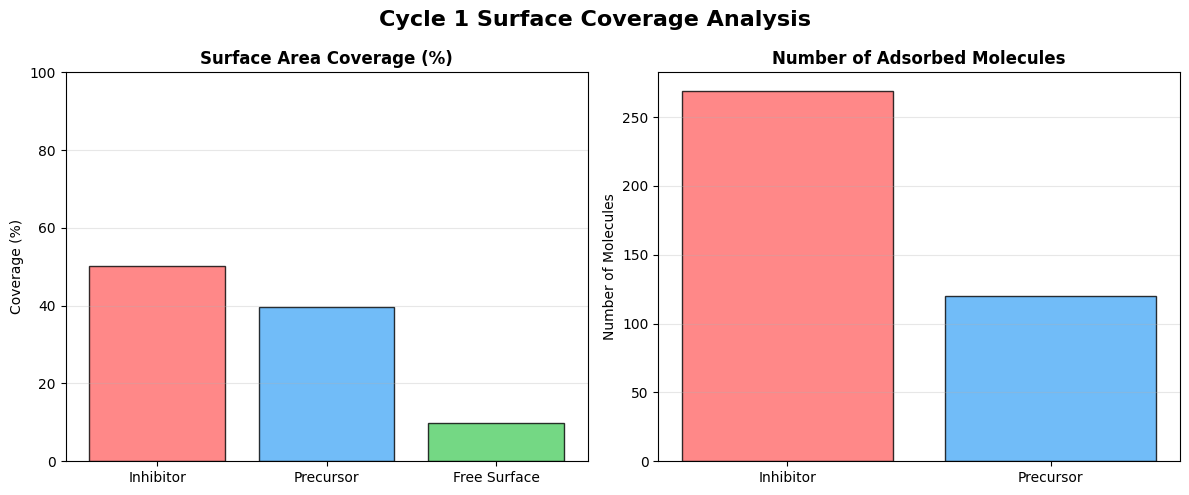

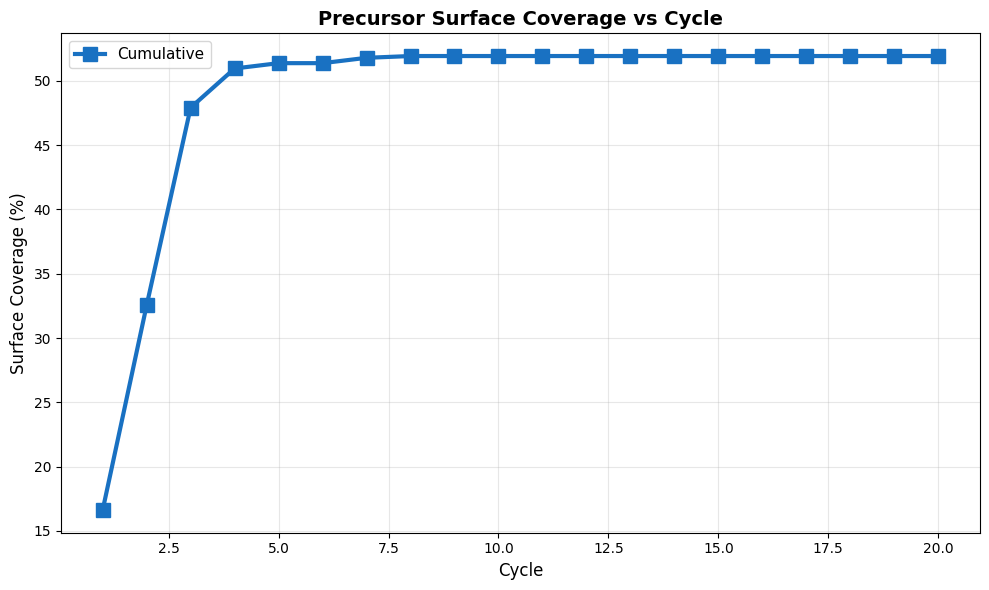

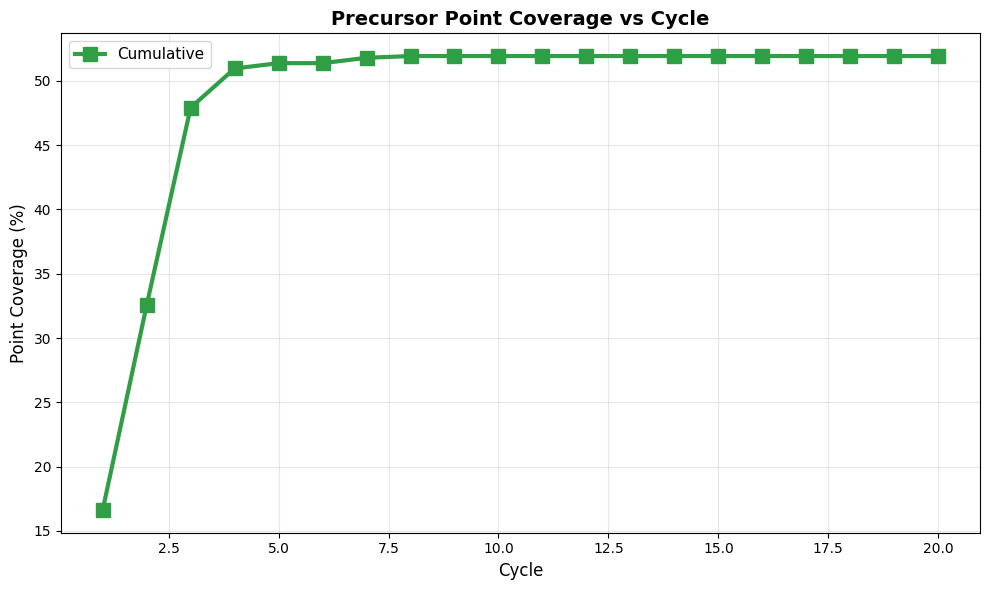

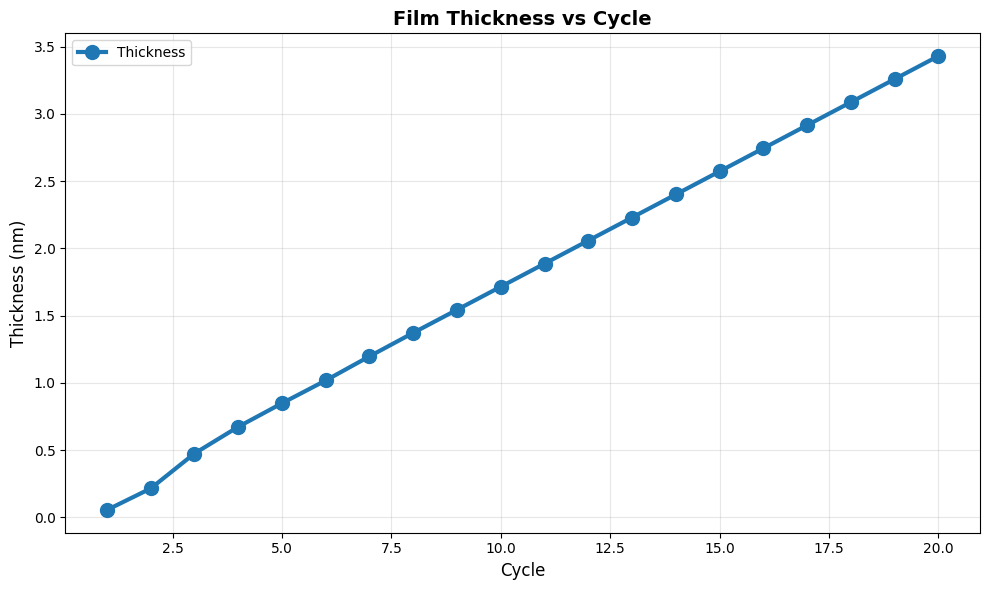

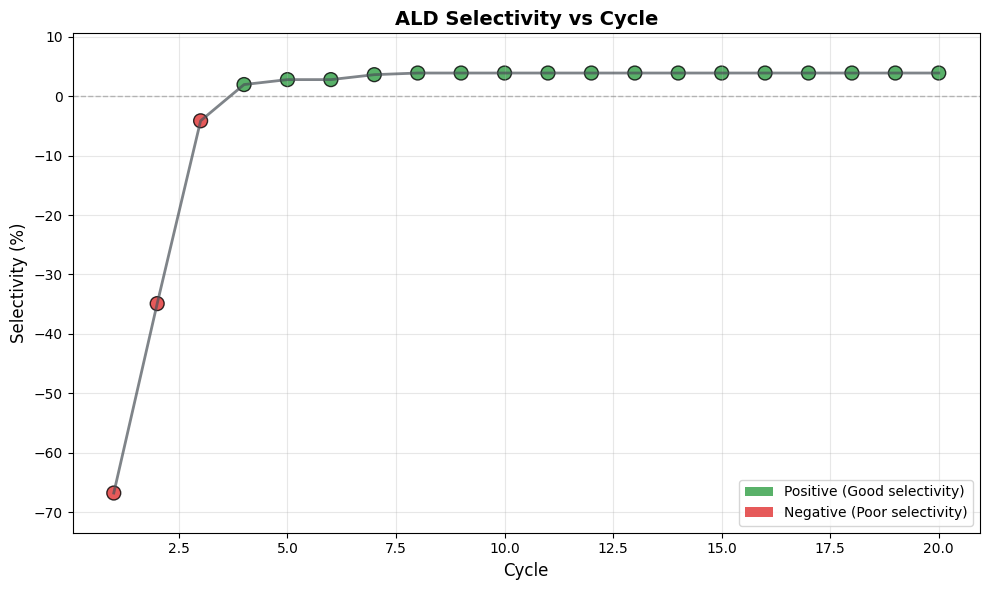

In [13]:
# Tạo analyzer từ dữ liệu mô phỏng
analyzer = create_analyzer_from_simulation_data(
    surface_area_nm2=surface_area_nm2,
    inhibitor_size_top_view_nm2=inhibitor_area_nm2,
    precursor_size_top_view_nm2=molecule_area_nm2,
    total_adsorption_sites=len(adsorption_sites),
    number_gas_inhibitors=number_gas_inhibitors,
    number_ads_inhibitors=number_ads_inhibitors,
    number_gas_precursor=number_gas_precursor,
    number_ads_precursor=number_ads_precursor,
    z_offset=2.0,
    density=6.95,  # SnO2 density
    molecular_mass=150.71  # SnO2 molecular mass
)

# Vẽ tất cả đồ thị
plots = plot_all_ald_analysis(analyzer)

# In báo cáo chi tiết
report = analyzer.generate_comprehensive_report()
print(report)

# Hiển thị các đồ thị
import matplotlib.pyplot as plt
plt.show()


# TEST 1

In [ ]:
'''
Đoạn code này mô phỏng quá trình hấp phụ của inhibitors và precursors trên bề mặt slab kèm chất đồng phản ứng H2O 
theo quy trình ALD với các chu kỳ được xác định rõ ràng.
n = số lần lặp quá trình trong 1 chu kỳ
N_gas = số phân tử trong 1 lần lặp
'''
from ase import Atoms
from ase.visualize import view
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree

# Đảm bảo có bán kính cho O (từ phản ứng H2O)
if 'O' not in radius:
    radius['O'] = 1.52  # Bán kính van der Waals của O, đơn vị Å (có thể điều chỉnh)

# Thêm các tham số mô phỏng (nếu chưa có)
n = 3  # Số lần lặp quá trình trong 1 chu kỳ
# N_gas = 5  # Số phân tử trong 1 lần lặp
# N = 2  # Số chu kỳ ALD
    
# Khởi tạo danh sách để lưu trữ các phân tử
inhibitor_phase_molecules = []  # Phân tử inhibitors trong giai đoạn khí (chỉ chu kỳ 1)
ads_inhibitor_molecules = []   # Phân tử inhibitors đã hấp phụ (chỉ chu kỳ 1)
ads_phase_molecules = []       # Phân tử precursors đã hấp phụ (tất cả chu kỳ)

# Mảng theo dõi số lượng phân tử
number_gas_inhibitors = np.array([])
number_ads_inhibitors = np.array([])
number_gas_precursor = np.array([])
number_ads_precursor = np.array([])

# Định nghĩa z-offset cho hấp phụ ontop (Sn trên O)
z_offset = 2.0  # Khoảng cách Sn-O, đơn vị Å (có thể điều chỉnh)

# Dictionary để lưu thông tin về chu kỳ của mỗi vị trí hấp phụ và phân tử
adsorption_cycle_info = {}  # key: (x, y, z) tuple của vị trí O, value: chu kỳ
molecules_by_cycle = {}     # key: chu kỳ, value: list các phân tử

# Khởi tạo cu_tree ban đầu với adsorption_sites
cu_tree = cKDTree(adsorption_sites)

# Khởi tạo thông tin chu kỳ cho các vị trí ban đầu (chu kỳ 0 - substrate)
for site in adsorption_sites:
    adsorption_cycle_info[tuple(site)] = 0

for cycle in range(1, N+1):
    print(f'\n{"="*50}')
    print(f'CYCLE {cycle}')
    print(f'{"="*50}')
    
    # Khởi tạo molecules_by_cycle cho chu kỳ hiện tại
    molecules_by_cycle[cycle] = []
    
    if cycle == 1:
        print('--- CHU KỲ 1: INHIBITORS + PRECURSORS + H2O ---')
        
        # ========== 1. GIAI ĐOẠN INHIBITORS (CHỈ CHU KỲ 1) ==========
        print(f'\n1. INHIBITORS PHASE - {n} lần lặp')
        inhibitor_phase_molecules = []  # Reset danh sách
        ads_inhibitor_molecules = []    # Reset danh sách
        
        # Thực hiện n lần lặp inhibitors
        for iteration in range(1, n+1):
            print(f'\n--- Inhibitor Iteration {iteration}/{n} ---')
            
            # 1a. Giai đoạn khí của inhibitors (N_gas phân tử trong 1 lần lặp)
            print(f'1a. Inhibitors Gas Phase - {N_gas} molecules')
            iteration_gas_molecules = []  # Phân tử khí trong lần lặp này
            
            for i in range(1, N_gas+1):
                print(f'  Gas molecule {i}/{N_gas}')
                
                # Sao chép phân tử từ inhibitor_atoms
                molecule = inhibitor_atoms.copy()
                
                # Tạo vị trí ngẫu nhiên và ma trận xoay
                pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
                
                # Áp dụng xoay cho phân tử
                molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
                molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
                molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
                
                # Dịch phân tử đến vị trí ngẫu nhiên
                offset = pos[0] - molecule[0].position
                molecule.translate(offset)
                
                # Kiểm tra steric hindrance CHỈ với molecules trong lần lặp hiện tại
                no_overlap = True
                if len(iteration_gas_molecules) > 0:
                    symbols = []
                    positions = []
                    
                    # Chỉ thêm từ lần lặp hiện tại
                    for prev_molecule in iteration_gas_molecules:
                        symbols.extend(prev_molecule.get_chemical_symbols())
                        positions.extend(prev_molecule.get_positions())
                    
                    all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                    
                    distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                    symbols1 = molecule.get_chemical_symbols()
                    symbols2 = all_gas_atoms.get_chemical_symbols()
                    radii1 = np.array([radius[s] for s in symbols1])
                    radii2 = np.array([radius[s] for s in symbols2])
                    radii_sums = radii1[:, None] + radii2[None, :]
                    
                    if not np.all(distances > radii_sums):
                        no_overlap = False
                
                if no_overlap:
                    print('    ✓ Gas molecule accepted')
                    iteration_gas_molecules.append(molecule.copy())
                else:
                    print('    ✗ Gas molecule rejected (steric hindrance)')
            
            # Thêm các phân tử khí của lần lặp này vào tổng
            inhibitor_phase_molecules.extend(iteration_gas_molecules)
            print(f'  Iteration {iteration} gas phase: {len(iteration_gas_molecules)} molecules accepted')
            
            # 1b. Giai đoạn hấp phụ của inhibitors trong lần lặp này
            print(f'1b. Inhibitors Adsorption Phase - Iteration {iteration}')
            
            for i, molecule in enumerate(tqdm(iteration_gas_molecules, desc=f"Adsorbing Inhibitors Iter {iteration}")):
                molecule_copy = molecule.copy()
                
                # Tìm vị trí hấp phụ gần nhất
                distances, indices = cu_tree.query(molecule_copy[0].position, k=min(MAX_SITES, len(adsorption_sites)))
                
                # Đảm bảo indices là mảng 1D
                if isinstance(indices, (int, np.integer)):
                    indices = [indices]
                
                adsorbed = False
                for k in indices:
                    if k >= len(adsorption_sites):
                        continue
                        
                    O_site = adsorption_sites[k]
                    ads_molecule = rotated_inhibitor.copy()
                    offset = O_site - ads_molecule[0].position
                    ads_molecule.translate(offset)
                    ads_molecule = rotate_molecule_z_axis(ads_molecule)
                    
                    # Kiểm tra steric hindrance với TẤT CẢ ads_inhibitor_molecules
                    no_overlap = True
                    if len(ads_inhibitor_molecules) > 0:
                        symbols = []
                        positions = []
                        for prev_ads_molecule in ads_inhibitor_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                        symbols1 = ads_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                    
                    if no_overlap:
                        ads_inhibitor_molecules.append(ads_molecule.copy())
                        adsorbed = True
                        break
                
                if not adsorbed:
                    print(f'    Molecule {i+1} could not be adsorbed')
            
            print(f'  Iteration {iteration} adsorption: {len(ads_inhibitor_molecules)} total inhibitors adsorbed')
        
        print(f'\nInhibitors Phase Completed:')
        print(f'  Total gas molecules: {len(inhibitor_phase_molecules)}')
        print(f'  Total adsorbed molecules: {len(ads_inhibitor_molecules)}')
    
    # ========== 2. GIAI ĐOẠN PRECURSORS (TẤT CẢ CHU KỲ) ==========
    print(f'\n2. PRECURSORS PHASE - {n} lần lặp (Cycle {cycle})')
    cycle_gas_molecules = []      # Tất cả gas molecules trong chu kỳ này
    cycle_ads_molecules = []      # Tất cả adsorbed molecules trong chu kỳ này
    
    # Xác định vị trí hấp phụ cho chu kỳ hiện tại
    if cycle == 1:
        adsorption_positions = adsorption_sites
        print(f'  Using original adsorption sites: {len(adsorption_positions)} sites')
    else:
        # Chu kỳ 2+: Sử dụng vị trí O từ ads_phase_molecules
        adsorption_positions = []
        adsorption_positions_cycle_map = {}  # Map từ vị trí đến chu kỳ gốc
        
        for molecule in ads_phase_molecules:
            symbols = molecule.get_chemical_symbols()
            positions = molecule.get_positions()
            
            # Tìm chu kỳ của phân tử này
            molecule_cycle = None
            for cycle_key, cycle_molecules in molecules_by_cycle.items():
                if molecule in cycle_molecules:
                    molecule_cycle = cycle_key
                    break
            
            if molecule_cycle is None:
                molecule_cycle = 1  # Default cho các phân tử từ chu kỳ 1
            
            for idx, symbol in enumerate(symbols):
                if symbol == 'O':
                    pos_tuple = tuple(positions[idx])
                    adsorption_positions.append(positions[idx])
                    adsorption_positions_cycle_map[len(adsorption_positions)-1] = molecule_cycle
        
        adsorption_positions = np.array(adsorption_positions)
        
        if len(adsorption_positions) == 0:
            print(f"  Warning: No O atoms found for adsorption in cycle {cycle}. Skipping precursor phase.")
            number_gas_inhibitors = np.append(number_gas_inhibitors, 0)
            number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
            number_gas_precursor = np.append(number_gas_precursor, 0)
            number_ads_precursor = np.append(number_ads_precursor, 0)
            continue
        
        print(f'  Using O atom positions from previous cycles: {len(adsorption_positions)} sites')
    
    # Tạo lại cu_tree với adsorption_positions
    cu_tree = cKDTree(adsorption_positions)
    
    # Thực hiện n lần lặp precursors
    for iteration in range(1, n+1):
        print(f'\n--- Precursor Iteration {iteration}/{n} ---')
        
        # 2a. Giai đoạn khí của precursors (N_gas phân tử trong 1 lần lặp)
        print(f'2a. Precursors Gas Phase - {N_gas} molecules')
        iteration_gas_molecules = []  # Phân tử khí trong lần lặp này
        
        for i in range(1, N_gas+1):
            print(f'  Gas molecule {i}/{N_gas}')
            
            # Sao chép phân tử từ atoms
            molecule = atoms.copy()
            
            # Tạo vị trí ngẫu nhiên và ma trận xoay
            pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
            
            # Áp dụng xoay cho phân tử
            molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
            molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
            molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
            
            # Dịch phân tử đến vị trí ngẫu nhiên
            offset = pos[0] - molecule[0].position
            molecule.translate(offset)
            
            # Kiểm tra steric hindrance CHỈ với molecules trong lần lặp hiện tại
            no_overlap = True
            if len(iteration_gas_molecules) > 0:
                symbols = []
                positions = []
                
                # Chỉ thêm từ lần lặp hiện tại
                for prev_molecule in iteration_gas_molecules:
                    symbols.extend(prev_molecule.get_chemical_symbols())
                    positions.extend(prev_molecule.get_positions())
                
                all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                symbols1 = molecule.get_chemical_symbols()
                symbols2 = all_gas_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if not np.all(distances > radii_sums):
                    no_overlap = False
            
            if no_overlap:
                print('    ✓ Gas molecule accepted')
                iteration_gas_molecules.append(molecule.copy())
            else:
                print('    ✗ Gas molecule rejected (steric hindrance)')
        
        # Thêm các phân tử khí của lần lặp này vào chu kỳ
        cycle_gas_molecules.extend(iteration_gas_molecules)
        print(f'  Iteration {iteration} gas phase: {len(iteration_gas_molecules)} molecules accepted')
        
        # 2b. Giai đoạn hấp phụ của precursors trong lần lặp này
        print(f'2b. Precursors Adsorption Phase - Iteration {iteration}')
        
        for i, molecule in enumerate(tqdm(iteration_gas_molecules, desc=f"Adsorbing Precursors Iter {iteration}")):
            molecule_copy = molecule.copy()
            
            # Tìm vị trí hấp phụ gần nhất
            k = min(MAX_SITES, len(adsorption_positions))
            distances, indices = cu_tree.query(molecule_copy[0].position, k=k)
            
            # Đảm bảo indices là mảng 1D
            if isinstance(indices, (int, np.integer)):
                indices = [indices]
            
            adsorbed = False
            for k_idx in indices:
                if k_idx >= len(adsorption_positions):
                    continue
                    
                O_site = adsorption_positions[k_idx]
                ads_molecule = rotated_adsorbate.copy()
                offset = O_site - ads_molecule[0].position
                
                # Xác định chu kỳ gốc của vị trí hấp phụ và target_layer
                if cycle == 1:
                    original_cycle = 0  # Substrate
                    target_layer = 1   # Layer 1 (trên substrate)
                    layer_z_offset = z_offset  # Layer 1 luôn có z_offset cố định từ substrate
                else:
                    original_cycle = adsorption_positions_cycle_map[k_idx]
                    target_layer = original_cycle + 1  # Layer tiếp theo
                    # Layer_z_offset được tính từ substrate (layer 0)
                    layer_z_offset = target_layer * z_offset
                
                # Thêm z-offset dựa trên target_layer
                offset += np.array([0, 0, layer_z_offset])
                    
                ads_molecule.translate(offset)
                ads_molecule = rotate_molecule_z_axis(ads_molecule)
                
                # LOGIC CHÍNH XÁC: Kiểm tra steric hindrance với các phân tử từ target_layer đến cycle hiện tại
                no_overlap = True
                blocking_layer = None
                
                # Kiểm tra steric hindrance với tất cả các layer từ target_layer đến cycle hiện tại
                for check_layer in range(target_layer, cycle + 1):
                    check_molecules = []
                    
                    if check_layer == cycle:
                        # Layer hiện tại: kiểm tra với các phân tử đã hấp phụ trong chu kỳ hiện tại
                        check_molecules = cycle_ads_molecules.copy()
                    else:
                        # Layer cũ hơn: kiểm tra với các phân tử ở layer đó
                        if check_layer in molecules_by_cycle:
                            check_molecules = molecules_by_cycle[check_layer].copy()
                    
                    if len(check_molecules) > 0:
                        # Tạo phân tử test với z_offset của layer đang kiểm tra
                        test_molecule = rotated_adsorbate.copy()
                        test_offset = O_site - test_molecule[0].position
                        # Z-offset được tính từ substrate (layer 0)
                        check_layer_z_offset = check_layer * z_offset
                        test_offset += np.array([0, 0, check_layer_z_offset])
                        test_molecule.translate(test_offset)
                        test_molecule = rotate_molecule_z_axis(test_molecule)
                        
                        symbols = []
                        positions = []
                        for prev_ads_molecule in check_molecules:
                            symbols.extend(prev_ads_molecule.get_chemical_symbols())
                            positions.extend(prev_ads_molecule.get_positions())
                        all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                        
                        distances = compute_distances_vectorized(test_molecule.positions, all_ads_atoms.positions)
                        symbols1 = test_molecule.get_chemical_symbols()
                        symbols2 = all_ads_atoms.get_chemical_symbols()
                        radii1 = np.array([radius[s] for s in symbols1])
                        radii2 = np.array([radius[s] for s in symbols2])
                        radii_sums = radii1[:, None] + radii2[None, :]
                        
                        if not np.all(distances > radii_sums):
                            no_overlap = False
                            blocking_layer = check_layer
                            break  # Dừng ngay khi gặp steric hindrance
                
                # Sử dụng ads_molecule đã tính toán với z_offset chính xác của target_layer
                # (ads_molecule đã được tính toán với layer_z_offset ở trên)
                
                if no_overlap:
                    cycle_ads_molecules.append(ads_molecule.copy())
                    print(f'    ✓ Molecule {i+1} adsorbed at layer {target_layer} (from cycle {original_cycle} site, z_offset={layer_z_offset:.1f})')
                    adsorbed = True
                    break
                else:
                    print(f'    ✗ Molecule {i+1} rejected at layer {target_layer} (blocked by layer {blocking_layer})')
            
            if not adsorbed:
                print(f'    Molecule {i+1} could not be adsorbed at any site')
        
        print(f'  Iteration {iteration} adsorption: {len(cycle_ads_molecules)} total precursors adsorbed in cycle')
    
    print(f'\nPrecursors Phase Completed (Cycle {cycle}):')
    print(f'  Total gas molecules: {len(cycle_gas_molecules)}')
    print(f'  Total adsorbed molecules: {len(cycle_ads_molecules)}')
    
    # ========== 3. GIAI ĐOẠN PHẢN ỨNG H2O (1 LẦN/CHU KỲ) ==========
    print(f'\n3. H2O REACTION PHASE (Cycle {cycle}) - 1 lần')
    print('  Starting H2O Reaction: Replacing all Cl with O')
    
    cl_replaced_total = 0
    for i, molecule in enumerate(tqdm(cycle_ads_molecules, desc="Processing H2O Reaction")):
        # Thay toàn bộ Cl bằng O
        symbols = molecule.get_chemical_symbols()
        positions = molecule.get_positions()
        cl_count = 0
        
        for idx, symbol in enumerate(symbols):
            if symbol == 'Cl':
                symbols[idx] = 'O'
                cl_count += 1
                # Cập nhật thông tin chu kỳ cho vị trí O mới
                adsorption_cycle_info[tuple(positions[idx])] = cycle
        
        molecule.set_chemical_symbols(symbols)
        cl_replaced_total += cl_count
        
        if cl_count > 0:
            print(f'  Molecule {i+1}: Replaced {cl_count} Cl atoms with O')
    
    # Lưu các phân tử của chu kỳ hiện tại vào molecules_by_cycle
    molecules_by_cycle[cycle] = cycle_ads_molecules.copy()
    
    # Thêm các phân tử đã phản ứng vào ads_phase_molecules
    ads_phase_molecules.extend(cycle_ads_molecules)
    print(f'  H2O Reaction Completed: {len(cycle_ads_molecules)} molecules, {cl_replaced_total} Cl→O replacements')
    
    # ========== 4. CẬP NHẬT SỐ LIỆU THỐNG KÊ ==========
    number_gas_inhibitors = np.append(number_gas_inhibitors, len(inhibitor_phase_molecules) if cycle == 1 else 0)
    number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules) if cycle == 1 else 0)
    number_gas_precursor = np.append(number_gas_precursor, len(cycle_gas_molecules))
    number_ads_precursor = np.append(number_ads_precursor, len(cycle_ads_molecules))
    
    print(f'\n{"="*20} END CYCLE {cycle} SUMMARY {"="*20}')
    print(f'Gas inhibitors: {len(inhibitor_phase_molecules) if cycle == 1 else 0}')
    print(f'Adsorbed inhibitors: {len(ads_inhibitor_molecules) if cycle == 1 else 0}')
    print(f'Gas precursors: {len(cycle_gas_molecules)}')
    print(f'Adsorbed precursors: {len(cycle_ads_molecules)}')
    print(f'Total molecules in system: {len(ads_inhibitor_molecules) + len(ads_phase_molecules)}')
    print(f'Molecules by layer: {[(k, len(v)) for k, v in molecules_by_cycle.items()]}')

In [ ]:
# ========== 5. HIỂN THỊ KẾT QUẢ CUỐI CÙNG ==========
print(f'\n{"="*60}')
print('FINAL SIMULATION RESULTS')
print(f'{"="*60}')
print(f'Total cycles completed: {N}')
print(f'Iterations per cycle: {n}')
print(f'Molecules per iteration: {N_gas}')
print(f'Total inhibitors adsorbed: {len(ads_inhibitor_molecules)}')
print(f'Total precursors processed through all cycles: {len(ads_phase_molecules)}')

# Gộp tất cả phân tử để hiển thị bằng nglview
all_adsorbed_molecules = []
all_adsorbed_molecules.extend(ads_inhibitor_molecules)  # Inhibitors từ chu kỳ 1
all_adsorbed_molecules.extend(ads_phase_molecules)      # Precursors từ tất cả chu kỳ

print(f'Total molecules for visualization: {len(all_adsorbed_molecules)}')

# Tạo structure tổng hợp để hiển thị
if len(all_adsorbed_molecules) > 0:
    # Gộp tất cả symbols và positions
    all_symbols = []
    all_positions = []
    
    # Thêm slab
    all_symbols.extend(slab.get_chemical_symbols())
    all_positions.extend(slab.get_positions())
    
    # Thêm tất cả phân tử đã hấp phụ
    for molecule in all_adsorbed_molecules:
        all_symbols.extend(molecule.get_chemical_symbols())
        all_positions.extend(molecule.get_positions())
    
    # Tạo structure cuối cùng
    final_structure = Atoms(symbols=all_symbols, positions=all_positions)
    print('✓ Final structure created successfully for visualization')
    
    # HIỂN THỊ KẾT QUẢ BẰNG NGLVIEW
    print('\n📊 VISUALIZATION')
    print('Displaying final structure with nglview...')
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('✓ Structure displayed successfully')
    except Exception as e:
        print(f'✗ Error displaying structure: {e}')
        print('You can manually visualize using: view(final_structure)')
    '''
        
else:
    print('⚠️  No molecules were adsorbed. Only slab will be available for visualization.')
    final_structure = slab.copy()
    view(final_structure, viewer='ngl')
    '''
    try:
        view(final_structure, viewer='ngl')
        print('✓ Slab-only structure displayed')
    except Exception as e:
        print(f'✗ Error displaying slab: {e}')
    '''

print('\n🎉 SIMULATION COMPLETED SUCCESSFULLY!')
print(f'Final structure variable: final_structure')
print(f'Total atoms in final structure: {len(final_structure)}')

# In thống kê chi tiết
print(f'\n📈 DETAILED STATISTICS:')
for i in range(len(number_gas_inhibitors)):
    cycle_num = i + 1
    print(f'Cycle {cycle_num}:')
    print(f'  - Gas inhibitors: {int(number_gas_inhibitors[i])}')
    print(f'  - Adsorbed inhibitors: {int(number_ads_inhibitors[i])}')
    print(f'  - Gas precursors: {int(number_gas_precursor[i])}')
    print(f'  - Adsorbed precursors: {int(number_ads_precursor[i])}')


view(final_structure, viewer='ngl')

# Run

In [ ]:
'''
Đoạn code này mô phỏng quá trình hấp phụ của inhibitors và precursors trên bề mặt slab kèm chất đồng phản ứng H2O.
'''
from ase import Atoms
from ase.visualize import view
import numpy as np
from tqdm import tqdm
from scipy.spatial import cKDTree  # Giả sử cu_tree là cKDTree

# Đảm bảo có bán kính cho O (từ phản ứng H2O)
if 'O' not in radius:
    radius['O'] = 1.52  # Bán kính van der Waals của O, đơn vị Å (có thể điều chỉnh)
    
# Khởi tạo danh sách để lưu trữ các phân tử
inhibitor_phase_molecules = []  # Phân tử inhibitors trong giai đoạn khí
ads_inhibitor_molecules = []   # Phân tử inhibitors đã hấp phụ
gas_phase_molecules = []       # Phân tử precursors trong giai đoạn khí
ads_phase_molecules = []       # Phân tử precursors đã hấp phụ
number_gas_inhibitors = np.array([])  # Số lượng inhibitors trong giai đoạn khí
number_ads_inhibitors = np.array([])  # Số lượng inhibitors đã hấp phụ
number_gas_precursor = np.array([])   # Số lượng precursors trong giai đoạn khí
number_ads_precursor = np.array([])   # Số lượng precursors đã hấp phụ

# Định nghĩa z-offset cho hấp phụ ontop (Sn trên O)
z_offset = 2.0  # Khoảng cách Sn-O, đơn vị Å (có thể điều chỉnh)

for j in range(1, N+1):
    print(f'Cycle {j}')
    
    if j == 1:
        # 1. Giai đoạn khí của inhibitors (chỉ trong chu kỳ 1)
        inhibitor_phase_molecules = []  # Reset danh sách
        for i in range(1, N_gas+1):
            print(f'Inhibitor: {i}')
            
            # Sao chép phân tử từ inhibitor_atoms
            molecule = inhibitor_atoms.copy()
            
            # Tạo vị trí ngẫu nhiên và ma trận xoay
            pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
            
            # Áp dụng xoay cho phân tử
            molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
            molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
            molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
            
            # Dịch phân tử đến vị trí ngẫu nhiên
            offset = pos[0] - molecule[0].position
            molecule.translate(offset)
            
            # Kiểm tra steric hindrance trong giai đoạn khí của inhibitors
            no_overlap = False
            if len(inhibitor_phase_molecules) > 0:
                symbols = []
                positions = []
                for prev_molecule in inhibitor_phase_molecules:
                    symbols.extend(prev_molecule.get_chemical_symbols())
                    positions.extend(prev_molecule.get_positions())
                all_gas_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
                symbols1 = molecule.get_chemical_symbols()
                symbols2 = all_gas_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if np.all(distances > radii_sums):
                    no_overlap = True
            else:
                no_overlap = True
            
            if no_overlap:
                print('Inhibitors Conditions Verified')
                inhibitor_phase_molecules.append(molecule.copy())
        
        print('Inhibitors Gas Layer Completed')
        
        # 2. Giai đoạn hấp phụ của inhibitors (chỉ trong chu kỳ 1)
        for i in tqdm(range(len(inhibitor_phase_molecules)), desc="Calculating Inhibitor Adsorption"):
            molecule = inhibitor_phase_molecules[i].copy()
            
            # Tìm vị trí hấp phụ gần nhất
            distances, indices = cu_tree.query(molecule[0].position, k=min(MAX_SITES, len(adsorption_sites)))
            
            # Đảm bảo indices là mảng 1D
            if isinstance(indices, (int, np.integer)):
                indices = [indices]
            
            for k in indices:
                if k >= len(adsorption_sites):  # Kiểm tra chỉ số hợp lệ
                    continue
                O_site = adsorption_sites[k]
                ads_molecule = rotated_inhibitor.copy()
                offset = O_site - ads_molecule[0].position
                ads_molecule.translate(offset)
                ads_molecule = rotate_molecule_z_axis(ads_molecule)
                
                # Kiểm tra steric hindrance với các inhibitors đã hấp phụ
                no_overlap = False
                if len(ads_inhibitor_molecules) > 0:
                    symbols = []
                    positions = []
                    for prev_ads_molecule in ads_inhibitor_molecules:
                        symbols.extend(prev_ads_molecule.get_chemical_symbols())
                        positions.extend(prev_ads_molecule.get_positions())
                    all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                    
                    distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                    symbols1 = ads_molecule.get_chemical_symbols()
                    symbols2 = all_ads_atoms.get_chemical_symbols()
                    radii1 = np.array([radius[s] for s in symbols1])
                    radii2 = np.array([radius[s] for s in symbols2])
                    radii_sums = radii1[:, None] + radii2[None, :]
                    
                    if np.all(distances > radii_sums):
                        no_overlap = True
                else:
                    no_overlap = True
                
                if no_overlap:
                    print('Inhibitor Adsorption On Substrate Successfully')
                    ads_inhibitor_molecules.append(ads_molecule.copy())
                    break
        
        print('Inhibitors Adsorption On Substrate Completed')
    
    # 3. Giai đoạn khí của precursors
    gas_phase_molecules = []  # Reset danh sách cho mỗi chu kỳ
    for i in range(1, N_gas+1):
        print(f'Precursor: {i}')
        
        # Sao chép phân tử từ atoms
        molecule = atoms.copy()
        
        # Tạo vị trí ngẫu nhiên và ma trận xoay
        pos, rx, ry, rz = generate_random_position_and_rotation(slab, adsorption_sites, 0.2, angle_range=(1, 360))
        
        # Áp dụng xoay cho phân tử
        molecule.rotate('x', np.arccos(rx[2, 2]), center=molecule[0].position)
        molecule.rotate('y', np.arccos(ry[0, 0]), center=molecule[0].position)
        molecule.rotate('z', np.arccos(rz[1, 1]), center=molecule[0].position)
        
        # Dịch phân tử đến vị trí ngẫu nhiên
        offset = pos[0] - molecule[0].position
        molecule.translate(offset)
        
        # Kiểm tra steric hindrance trong giai đoạn khí của precursors
        no_overlap = False
        if len(gas_phase_molecules) > 0:
            symbols = []
            positions = []
            for prev_molecule in gas_phase_molecules:
                symbols.extend(prev_molecule.get_chemical_symbols())
                positions.extend(prev_molecule.get_positions())
            all_gas_atoms = Atoms(symbols=symbols, positions=positions)
            
            distances = compute_distances_vectorized(molecule.positions, all_gas_atoms.positions)
            symbols1 = molecule.get_chemical_symbols()
            symbols2 = all_gas_atoms.get_chemical_symbols()
            radii1 = np.array([radius[s] for s in symbols1])
            radii2 = np.array([radius[s] for s in symbols2])
            radii_sums = radii1[:, None] + radii2[None, :]
            
            if np.all(distances > radii_sums):
                no_overlap = True
        else:
            no_overlap = True
        
        if no_overlap:
            print('Precursors Conditions Verified')
            gas_phase_molecules.append(molecule.copy())
    
    print('Precursors Gas Layer Completed')
    
    # 4. Giai đoạn hấp phụ của precursors
    if j == 1:
        # Chu kỳ 1: Sử dụng adsorption_sites
        adsorption_positions = adsorption_sites
        cu_tree = cKDTree(adsorption_positions)  # Khởi tạo lại cu_tree
    else:
        # Chu kỳ 2 trở đi: Sử dụng vị trí của nguyên tử O từ ads_phase_molecules
        adsorption_positions = []
        for molecule in ads_phase_molecules:
            symbols = molecule.get_chemical_symbols()
            positions = molecule.get_positions()
            for idx, symbol in enumerate(symbols):
                if symbol == 'O':
                    adsorption_positions.append(positions[idx])
        adsorption_positions = np.array(adsorption_positions)
        if len(adsorption_positions) == 0:
            print(f"Warning: No O atoms found for adsorption in cycle {j}. Skipping precursor adsorption.")
            number_gas_precursor = np.append(number_gas_precursor, len(gas_phase_molecules))
            number_ads_precursor = np.append(number_ads_precursor, 0)
            continue
        cu_tree = cKDTree(adsorption_positions)  # Khởi tạo lại cu_tree với adsorption_positions mới
    
    new_ads_molecules = []  # Danh sách tạm để lưu trữ precursors hấp phụ trong chu kỳ này
    for i in tqdm(range(len(gas_phase_molecules)), desc="Calculating Precursor Adsorption"):
        molecule = gas_phase_molecules[i].copy()
        
        # Tìm vị trí hấp phụ gần nhất
        k = min(MAX_SITES, len(adsorption_positions))  # Giới hạn k
        distances, indices = cu_tree.query(molecule[0].position, k=k)
        
        # Đảm bảo indices là mảng 1D
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
        
        for k_idx in indices:
            if k_idx >= len(adsorption_positions):  # Kiểm tra chỉ số hợp lệ
                continue
            O_site = adsorption_positions[k_idx]
            ads_molecule = rotated_adsorbate.copy()
            offset = O_site - ads_molecule[0].position
            if j > 1:
                offset += np.array([0, 0, z_offset])  # Thêm z-offset cho chu kỳ 2+
            ads_molecule.translate(offset)
            ads_molecule = rotate_molecule_z_axis(ads_molecule)
            
            # Kiểm tra steric hindrance chỉ với các precursors đã hấp phụ trong chu kỳ này
            no_overlap = False
            if len(new_ads_molecules) > 0:
                symbols = []
                positions = []
                for prev_ads_molecule in new_ads_molecules:
                    symbols.extend(prev_ads_molecule.get_chemical_symbols())
                    positions.extend(prev_ads_molecule.get_positions())
                all_ads_atoms = Atoms(symbols=symbols, positions=positions)
                
                distances = compute_distances_vectorized(ads_molecule.positions, all_ads_atoms.positions)
                symbols1 = ads_molecule.get_chemical_symbols()
                symbols2 = all_ads_atoms.get_chemical_symbols()
                radii1 = np.array([radius[s] for s in symbols1])
                radii2 = np.array([radius[s] for s in symbols2])
                radii_sums = radii1[:, None] + radii2[None, :]
                
                if np.all(distances > radii_sums):
                    no_overlap = True
            else:
                no_overlap = True
            
            if no_overlap:
                print('Precursor Adsorption On Substrate Successfully')
                new_ads_molecules.append(ads_molecule.copy())
                break
    
    print('Precursors Adsorption On Substrate Completed')
    
    # 5. Giai đoạn phản ứng với H2O: Thay toàn bộ Cl bằng O
    print('Starting H2O Reaction Phase')
    for i in tqdm(range(len(new_ads_molecules)), desc="Processing H2O Reaction"):
        molecule = new_ads_molecules[i]
        
        # Thay toàn bộ Cl bằng O
        symbols = molecule.get_chemical_symbols()
        for idx, symbol in enumerate(symbols):
            if symbol == 'Cl':
                symbols[idx] = 'O'
        molecule.set_chemical_symbols(symbols)
        print(f'Replaced all Cl with O in molecule {i+1}')
    
    ads_phase_molecules.extend(new_ads_molecules)
    print('H2O Reaction Phase Completed')
    
    # Cập nhật số lượng phân tử
    number_gas_inhibitors = np.append(number_gas_inhibitors, len(inhibitor_phase_molecules) if j == 1 else 0)
    number_ads_inhibitors = np.append(number_ads_inhibitors, len(ads_inhibitor_molecules))
    number_gas_precursor = np.append(number_gas_precursor, len(gas_phase_molecules))
    number_ads_precursor = np.append(number_ads_precursor, len(new_ads_molecules))


In [ ]:
# Hiển thị cấu trúc
if len(ads_phase_molecules) == 0 and len(ads_inhibitor_molecules) == 0:
    print("Warning: No adsorbed molecules (inhibitors or precursors) found. Visualization will only show the slab.")
    combined = slab.copy()
else:
    # Gộp tất cả các phân tử hấp phụ (inhibitors và precursors) thành một đối tượng Atoms
    adsorbates = Atoms()
    for molecule in ads_inhibitor_molecules + ads_phase_molecules:
        adsorbates += molecule
    
    # Thiết lập ô đơn vị và điều kiện biên cho adsorbates
    adsorbates.cell = slab.cell
    adsorbates.pbc = slab.pbc

    # Kết hợp slab và adsorbates
    combined = slab + adsorbates

# Hiển thị cấu trúc bằng ASE view với nglview
view(combined, viewer='ngl')